In [400]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb  
sb.set_style('darkgrid')
from scipy import stats
from statsmodels.graphics.api import qqplot
from sklearn.metrics import r2_score
from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')

In [2]:
daily_data = pd.read_csv('../exchangeratedata/daily_full.csv', skiprows=7, header=0)
monthly_data = pd.read_csv('../exchangeratedata/monthly_rates.csv', skiprows=11, header=0)

In [3]:
daily_data['datetime'] = pd.to_datetime(daily_data['DATE'])
daily_data['dayofweek'] = daily_data['datetime'].apply(lambda row: row.dayofweek)
weekly_data = daily_data[daily_data['dayofweek'] == 4]

In [4]:
weekly_data.dtypes
print weekly_data.head(5)

           DATE  IUDBEDR  IUDSOIA  XUDLDS1  XUDLERS  XUDLUSS   datetime  \
3   07 Jan 2000     5.50   4.4172   1.6374   1.5909   1.6372 2000-01-07   
8   14 Jan 2000     5.75   5.0126   1.6351   1.6152   1.6349 2000-01-14   
13  21 Jan 2000     5.75   5.8912   1.6506   1.6391   1.6506 2000-01-21   
18  28 Jan 2000     5.75   6.0424   1.6198   1.6529   1.6198 2000-01-28   
23  04 Feb 2000     5.75   5.6334   1.5885   1.6214   1.5886 2000-02-04   

    dayofweek  
3           4  
8           4  
13          4  
18          4  
23          4  


## Univariate Model

In [5]:
UK_US = pd.DataFrame()
UK_US['UK_US']=weekly_data['XUDLUSS']
UK_US['LIBOR']=weekly_data['IUDSOIA']
UK_US = UK_US.set_index(weekly_data['datetime'].values) # index has to be the variable depicting date-time information

UK_EU = pd.DataFrame()
UK_EU['UK_EU']=weekly_data['XUDLERS']
UK_EU['LIBOR']=weekly_data['IUDSOIA']
UK_EU.set_index(weekly_data['datetime'].values)

# dates = pd.DatetimeIndex(UK_US.index)
# dates[:'2000-03-10']
ts = UK_US['UK_US']
libor = UK_US['LIBOR']

In [6]:
ts['2000-01-07']

1.6372

In [7]:
libor['2000-01-07']

4.4172000000000002

### Checking stationarity of time series

Can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- an autocovariance that does not depend on time

Determine stationarity using 
1. the Dickey-Fuller Test: the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
2. Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

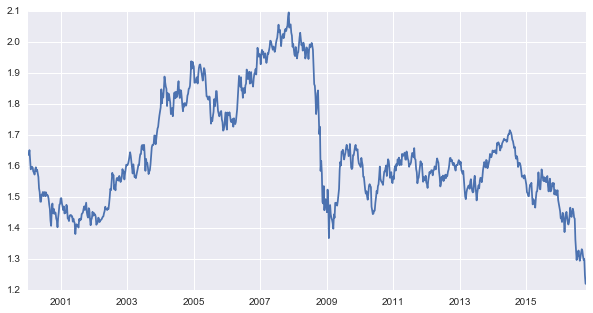

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(UK_US['UK_US'])

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


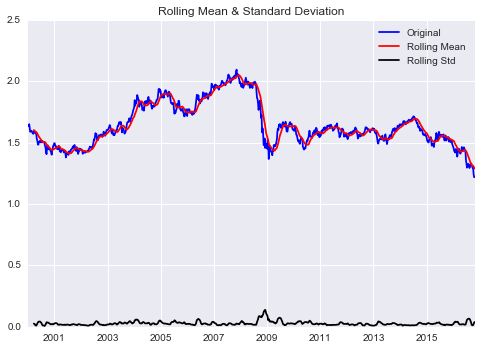

Results of Dickey-Fuller Test:
Test Statistic                  -1.020120
p-value                          0.745855
#Lags Used                       3.000000
Number of Observations Used    848.000000
Critical Value (5%)             -2.864954
Critical Value (1%)             -3.438085
Critical Value (10%)            -2.568588
dtype: float64


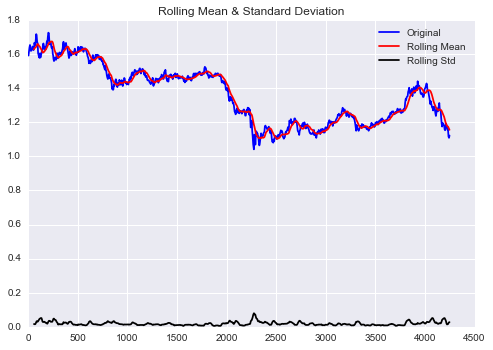

Results of Dickey-Fuller Test:
Test Statistic                  -1.295231
p-value                          0.631351
#Lags Used                       2.000000
Number of Observations Used    849.000000
Critical Value (5%)             -2.864950
Critical Value (1%)             -3.438076
Critical Value (10%)            -2.568586
dtype: float64


In [10]:
test_stationarity(UK_US['UK_US'])
test_stationarity(UK_EU['UK_EU'])

For both series, the test statistic is more than the critical values so the series are not stationary. Note that the signed values should be compared and not the absolute values.

### Make the time series stationary

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

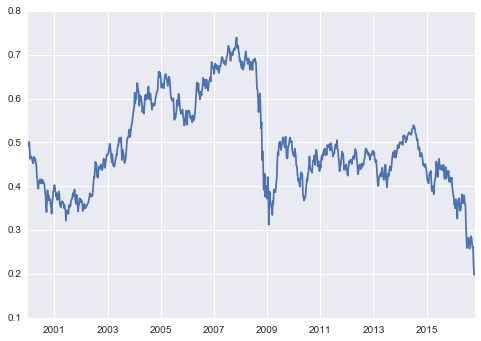

In [11]:
ts = UK_US['UK_US']
ts_log = np.log(UK_US['UK_US'])
plt.plot(ts_log)

### 1. Subtract 3 month moving average

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


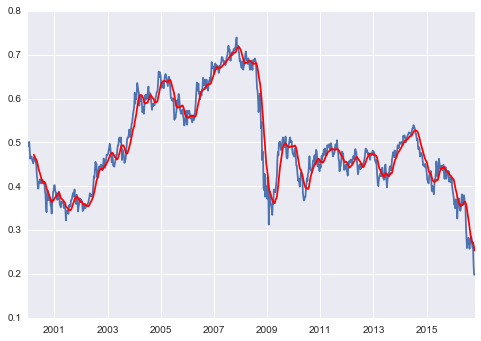

In [12]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


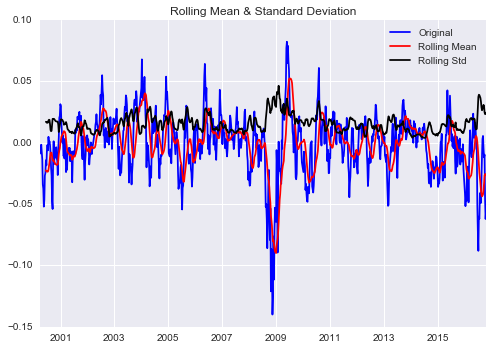

Results of Dickey-Fuller Test:
Test Statistic                  -5.109795
p-value                          0.000013
#Lags Used                      11.000000
Number of Observations Used    829.000000
Critical Value (5%)             -2.865033
Critical Value (1%)             -3.438263
Critical Value (10%)            -2.568630
dtype: float64


In [13]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)



The test statistic is smaller than the 1% critical value so with 99% confidence we can say that the series is stationary

### 2. Exponentially weighted moving average

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


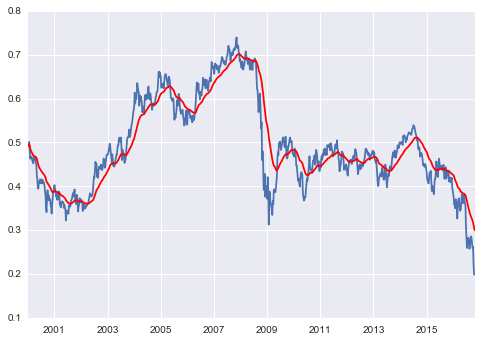

In [14]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


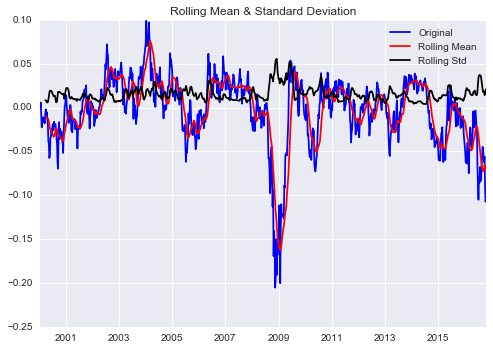

Results of Dickey-Fuller Test:
Test Statistic                  -3.817219
p-value                          0.002736
#Lags Used                       9.000000
Number of Observations Used    842.000000
Critical Value (5%)             -2.864979
Critical Value (1%)             -3.438140
Critical Value (10%)            -2.568601
dtype: float64


In [15]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This also results in a test statistic which is smaller than the 1% critical value

### 3. Differencing

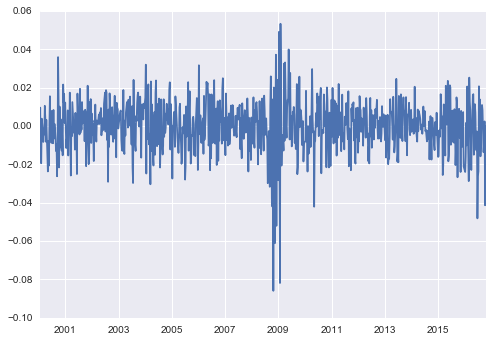

In [16]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_diff = UK_US['UK_US'] - UK_US['UK_US'].shift()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


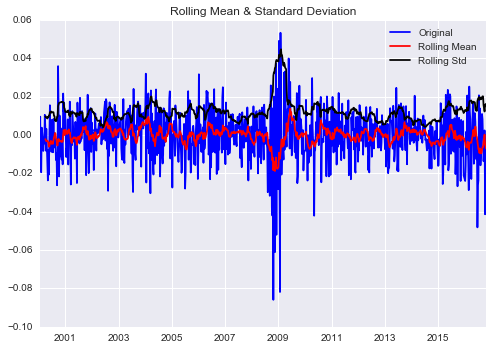

Results of Dickey-Fuller Test:
Test Statistic                -8.990065e+00
p-value                        6.930526e-15
#Lags Used                     8.000000e+00
Number of Observations Used    8.420000e+02
Critical Value (5%)           -2.864979e+00
Critical Value (1%)           -3.438140e+00
Critical Value (10%)          -2.568601e+00
dtype: float64


In [17]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

The test statistic is much lower than the 1% critical value (-16 comared to -3)

## Forecasting 

### ARIMA models

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers.

- Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [18]:
from statsmodels.tsa.stattools import acf, pacf

In [19]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

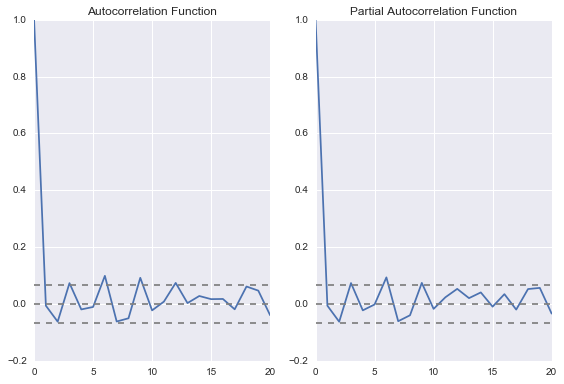

In [20]:
#Plot ACF: 
plt.figure()
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values for the ARIMA model as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time - in this case p=6.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time - in this case q=6.


## ARIMA models

There are three models we could try

- AutoRegressive model - only set the p and d terms
- Moving Average model - only set the d and q terms
- Combined model - set all three terms

In [21]:
from statsmodels.tsa.arima_model import ARIMA

### AR model

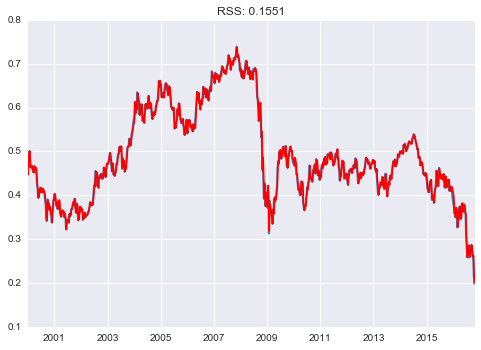

In [22]:
model = ARIMA(ts_log, order=(6, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log)**2))

### AR model with LIBOR


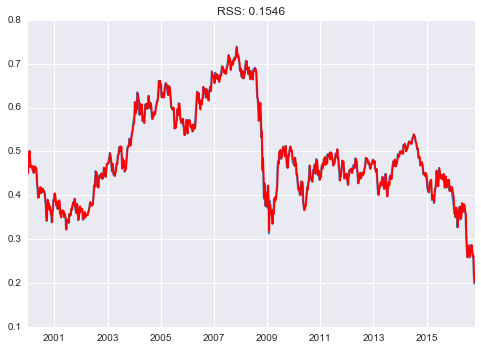

In [23]:
model = ARIMA(ts_log, order=(6, 0, 0), exog=libor)  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log)**2))

### MA model

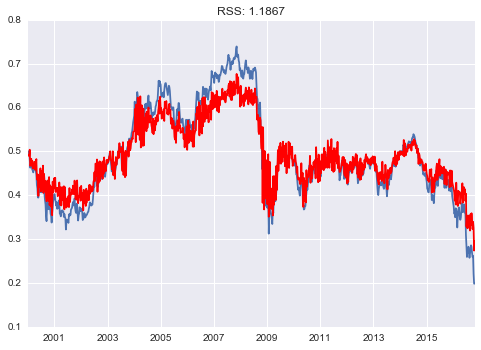

In [24]:
model = ARIMA(ts_log, order=(0,0, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log)**2))

### MA Model with LIBOR

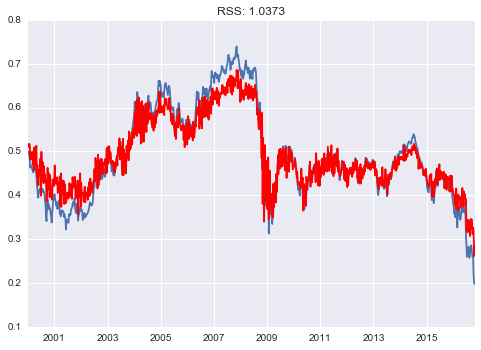

In [25]:
model = ARIMA(ts_log, order=(0,0, 2), exog = libor)  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log)**2))

### Combined

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


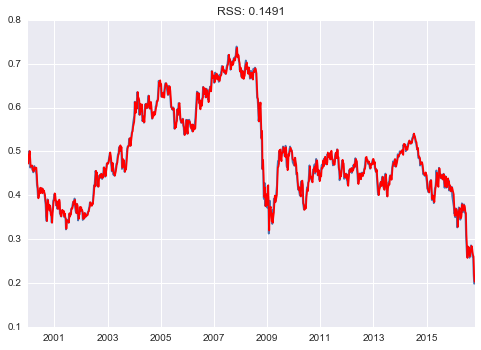

In [26]:
model = ARIMA(ts_log, order=(6, 0, 5))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log)**2))

### ARIMA model with LIBOR

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


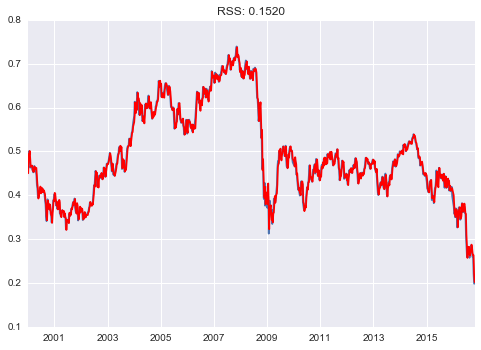

In [27]:
model = ARIMA(ts_log, order=(6, 0, 4), exog=libor)  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log)**2))

In [24]:
## adjusted R2

In [25]:
# # trend = sm.tsa.arma_order_select_ic(ts, ic=['aic', 'bic'])
# model = statsmodels.tsa.arima_model.ARMA(ts_diff, trend.aic_min_order)  
# results_ARMA = model.fit(disp=-1)  
# plt.plot(ts_diff)
# plt.plot(results_ARMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARMA.fittedvalues-ts_diff)**2))

## Take it back to the original scale

In [85]:
def transform_back(results):
    predictions_diff = pd.Series(results.fittedvalues, copy=True)
#     print predictions_diff[0:10]
    predictions_diff_cumsum = predictions_diff.cumsum()
#     print predictions_diff_cumsum[0:10]
    predictions_diff = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_diff = predictions_diff.add(predictions_diff_cumsum,fill_value=0)
    predictions_diff_exp = np.exp(predictions_diff)
#     print predictions_diff_exp[0:10]
#     print ts[0:10]
#     return predictions_diff_exp
    return np.exp(results.fittedvalues)


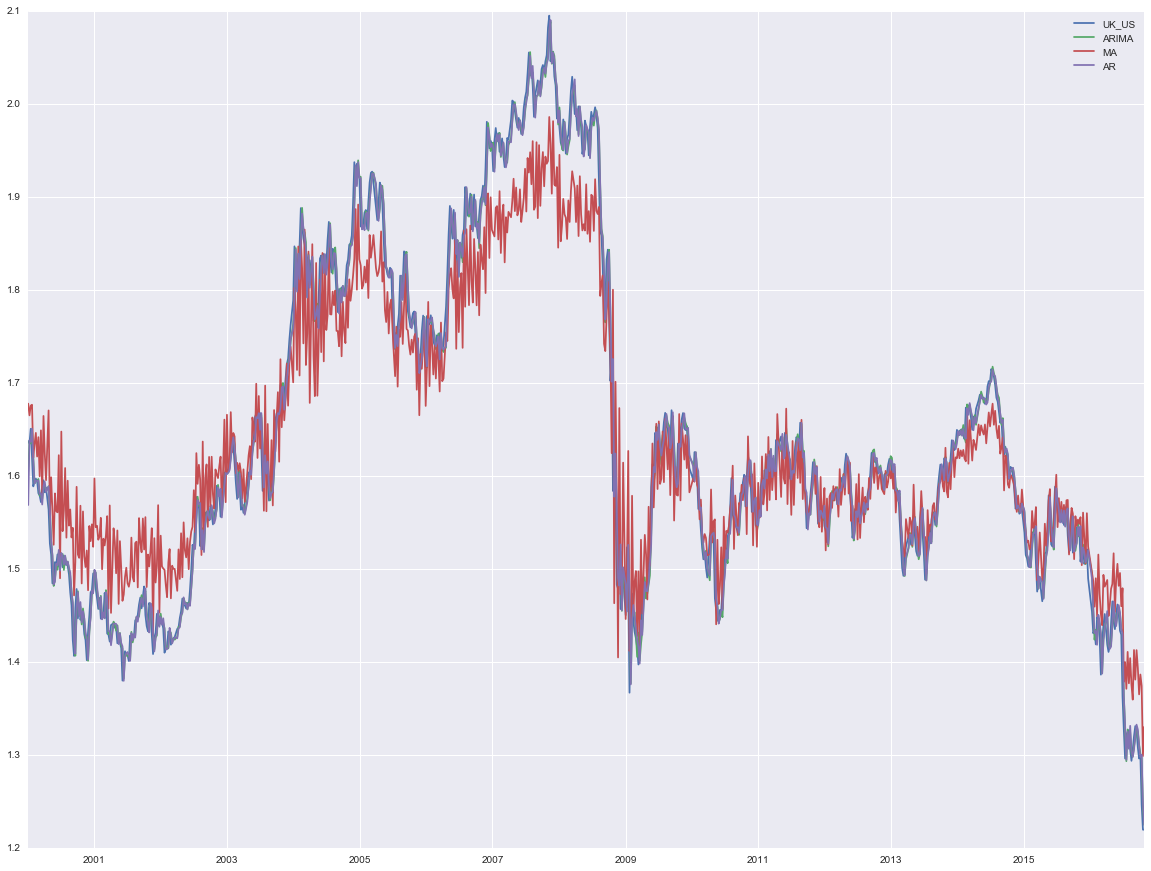

In [86]:
plt.figure(figsize=(20,15))
plt.plot(UK_US['UK_US'])
# plt.plot(transform_back(results_ARMA), label='ARMA')
plt.plot(transform_back(results_ARIMA), label='ARIMA')
plt.plot(transform_back(results_MA), label='MA')
plt.plot(transform_back(results_AR), label='AR')
plt.legend()
# plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_exp-UK_US['UK_US'])**2)/len(UK_US['UK_US'])))

### Fit to smaller sections of the data 

- Split the data by year
- Fit the model to the first 6 months of the year and predict on the remaining 6 months
- For the next year fit on the first year and 6 months of the second year etc (so the size of the training set increases)

In [47]:
def score(y, yhat):
    return sum((yhat-y)**2)

def forecast_cumulatively(ts):
    plt.figure(figsize=(50,100))
    j=0
    for year in range(2001, 2015): 
        ts_train = ts[str(2000):str(year)+str('-06')] # first 6 months of the year
        ts_years = ts[str(2000):str(year)]
        ts_forecast_period = ts[str(year)+str('-07'): str(year)+str('-12')]
        model = ARIMA(ts_train, order=(6, 0, 0))  
        results_ARIMA = model.fit(disp=-1)  
        n_weeks = len(ts_forecast_period)
        forecast = results_ARIMA.forecast(n_weeks)[0] # 6 month forecast
        forecast_series = pd.DataFrame({'forecast':forecast})
        forecast_series = forecast_series.set_index(ts_forecast_period.index)
        j+=1
        plt.subplot(8, 2, j)
        plt.plot(ts_years, label='us/uk exchange rate')
        plt.plot(results_ARIMA.fittedvalues, 'r--')
        plt.plot(forecast_series['forecast'], 'r--', label='forecast')
        plt.title('RMSE: %.4f'% score(ts_forecast_period, forecast), fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30, loc='best')
#         plt.title('RMSE', score(ts_forecast_period.values, forecast))
#     lags_moving_avs = np.zeros((7, 7))
#     for lag in range(0,7):
#         for ma in range(0,7):
#             model = ARIMA(ts_train, order=(lag, 0, ma))  
#             results_ARIMA = model.fit(disp=-1)  
#             forecast = results_ARIMA.forecast(18) # 6 month forecast
#             plt.subplot(ts_years)
#             plt.plot(forecast)
#         lags_moving_avs[lag, ma] = score(forecast, ts_forecast_period)
    
#     return lags_moving_avs

In [48]:
# forecast_cumulatively(ts)

In [49]:
def forecast_by_year(ts):
    plt.figure(figsize=(50,100))
    j=0
    for year in range(2001, 2015): 
        ts_train = ts[str(year)+str('-01'):str(year)+str('-09')] # first 6 months of the year
        ts_forecast_period = ts[str(year)+str('-10'): str(year)+str('-12')]
        model = ARIMA(ts_train, order=(5, 0, 0))  
        results_ARIMA = model.fit(disp=-1)  
        n_weeks = len(ts_forecast_period)
        forecast = results_ARIMA.forecast(n_weeks)[0] # 6 month forecast
        forecast_series = pd.DataFrame({'forecast':forecast})
        forecast_series = forecast_series.set_index(ts_forecast_period.index)
        j+=1
        plt.subplot(8, 2, j)
        plt.plot(ts[str(year)], label='us/uk exchange rate')
        plt.plot(results_ARIMA.fittedvalues, 'g--', label='fitted values')
        plt.plot(forecast_series['forecast'], 'r--', label='forecast')
        plt.title('RMSE: %.4f'% score(ts_forecast_period, forecast), fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30, loc='best')

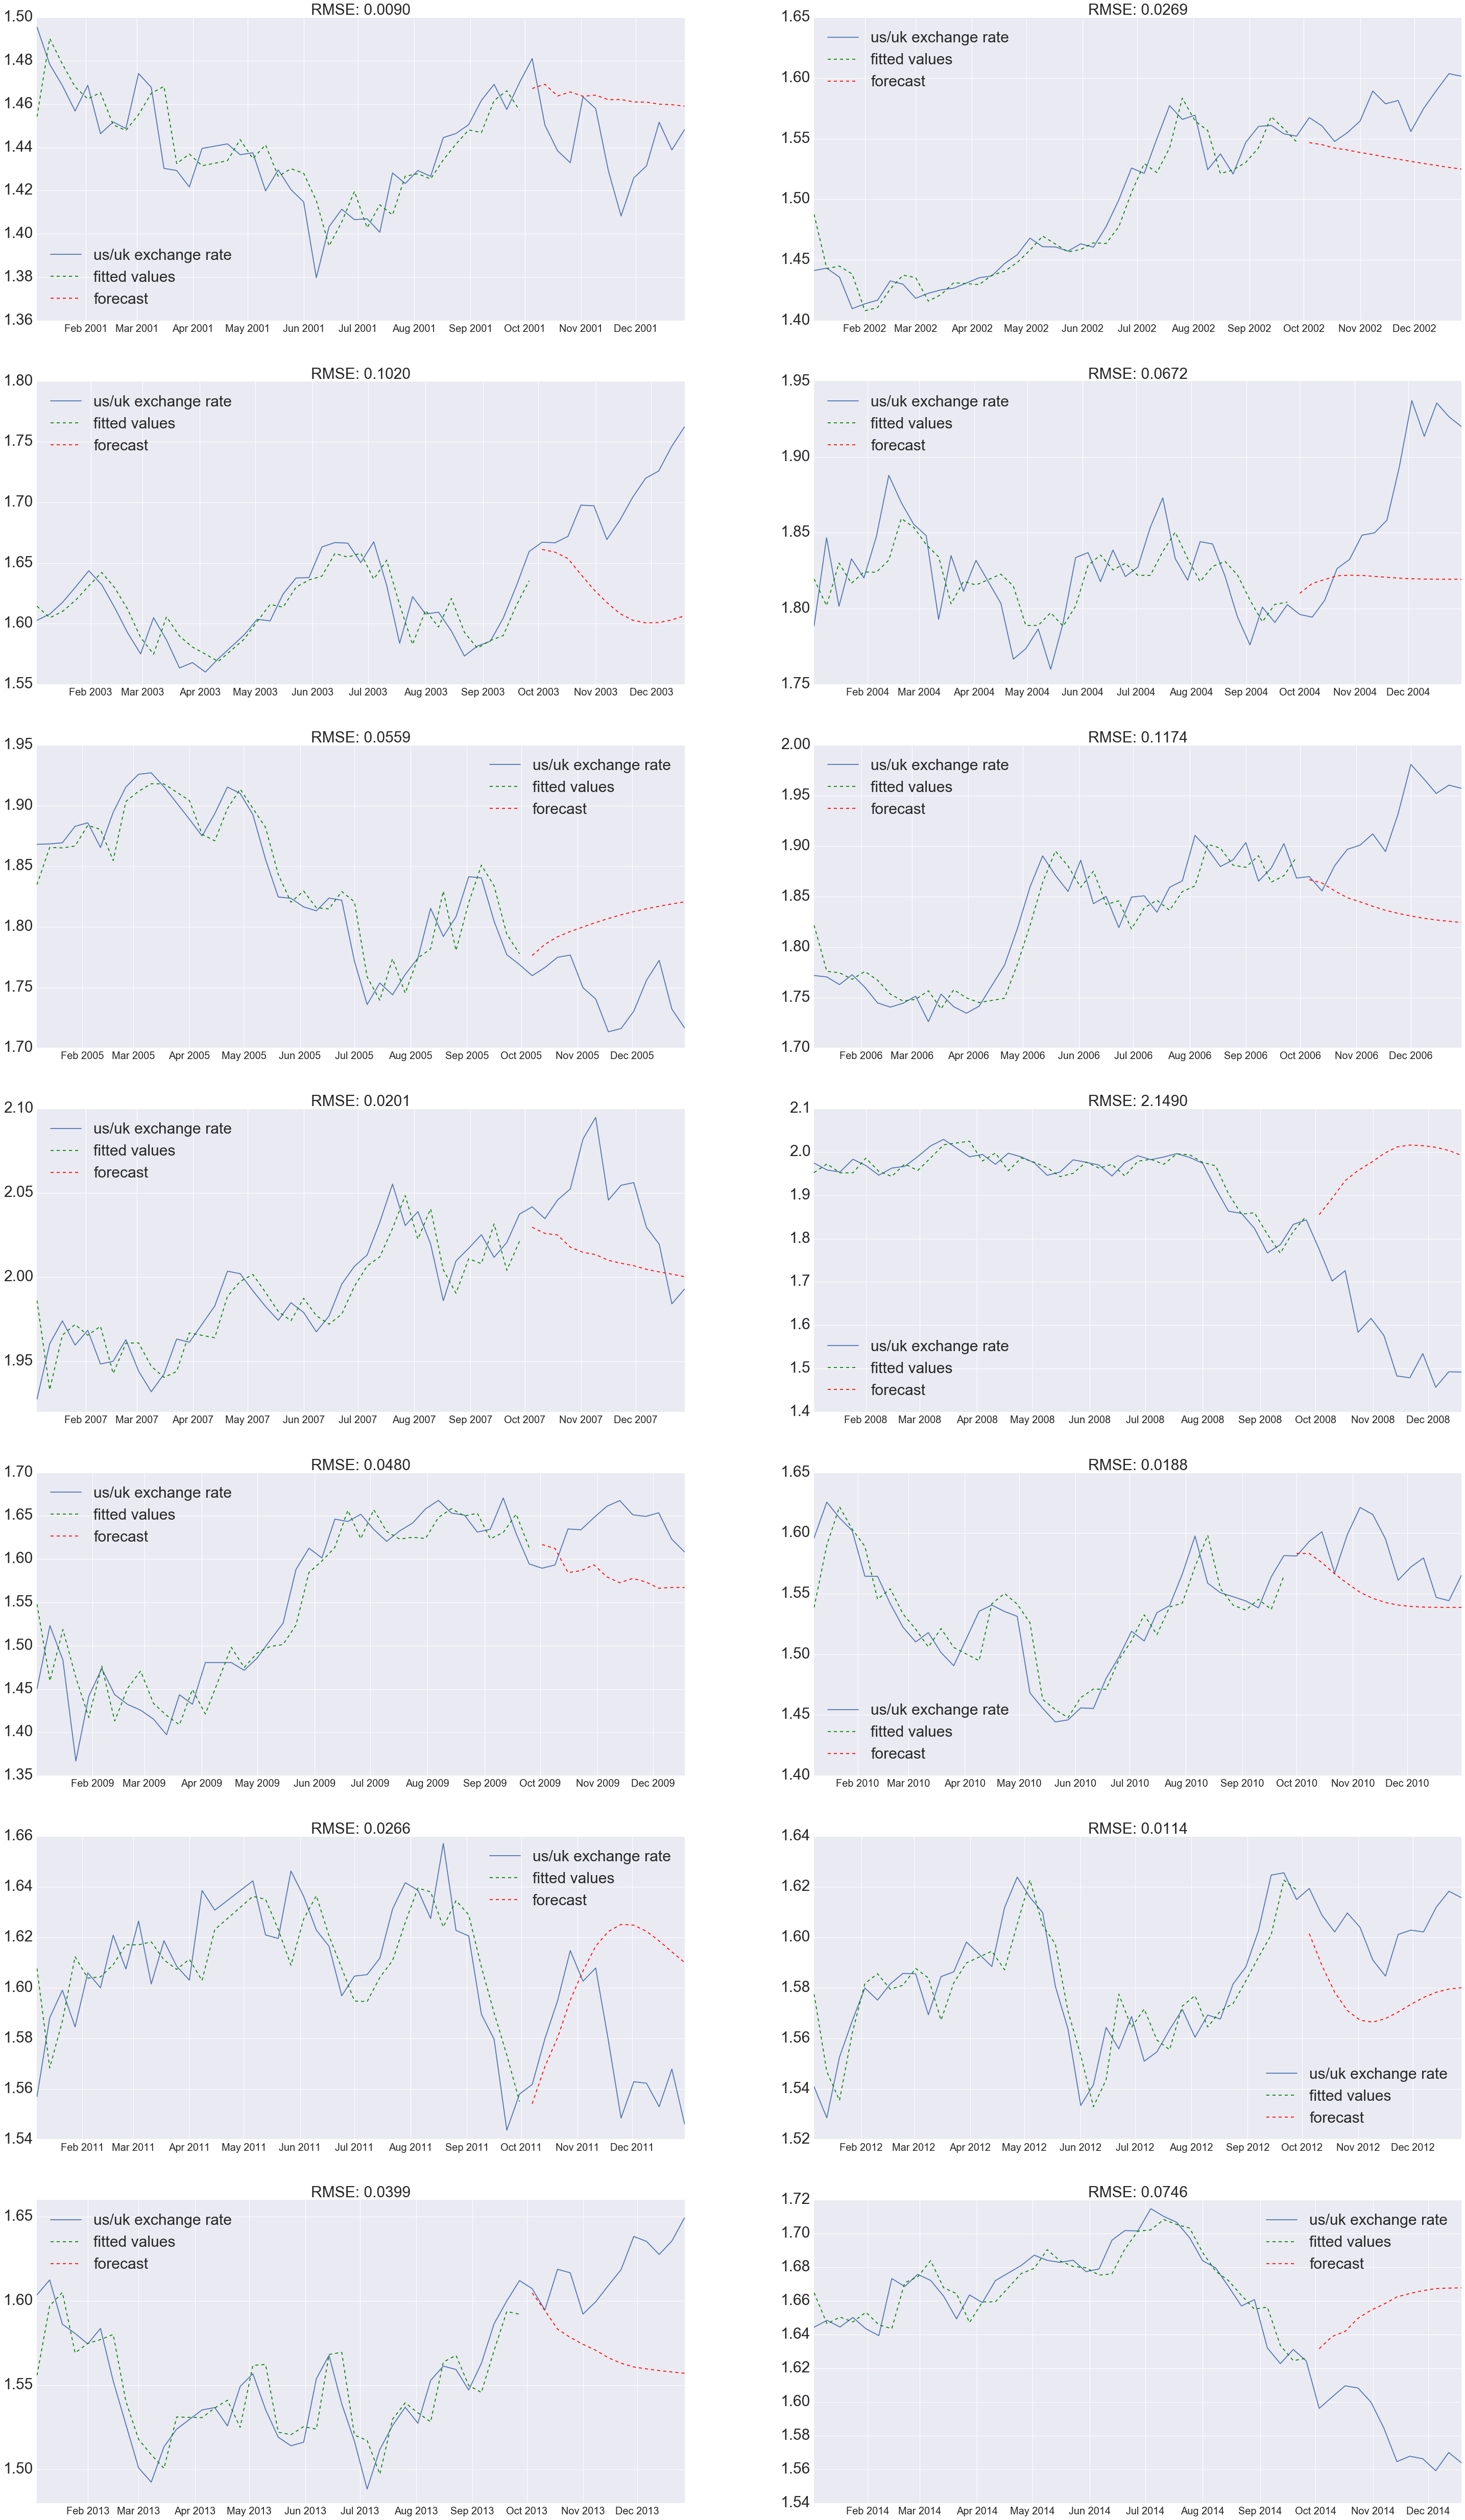

In [50]:
forecast_by_year(ts)

In [51]:
def forecast_by_year_libor(ts):
    plt.figure(figsize=(50,100))
    j=0
    for year in range(2001, 2015): 
        ts_train = ts[str(year)+str('-01'):str(year)+str('-09')] # first 6 months of the year
        ts_forecast_period = ts[str(year)+str('-10'): str(year)+str('-12')]
        model = ARIMA(ts_train, order=(5, 0, 0), exog=libor)  
        results_ARIMA = model.fit(disp=-1)  
        n_weeks = len(ts_forecast_period)
        forecast = results_ARIMA.forecast(n_weeks)[0] # 6 month forecast
        forecast_series = pd.DataFrame({'forecast':forecast})
        forecast_series = forecast_series.set_index(ts_forecast_period.index)
        j+=1
        plt.subplot(8, 2, j)
        plt.plot(ts[str(year)], label='us/uk exchange rate')
        plt.plot(results_ARIMA.fittedvalues, 'g--', label='fitted values')
        plt.plot(forecast_series['forecast'], 'r--', label='forecast')
        plt.title('RMSE: %.4f'% score(ts_forecast_period, forecast), fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30, loc='best')

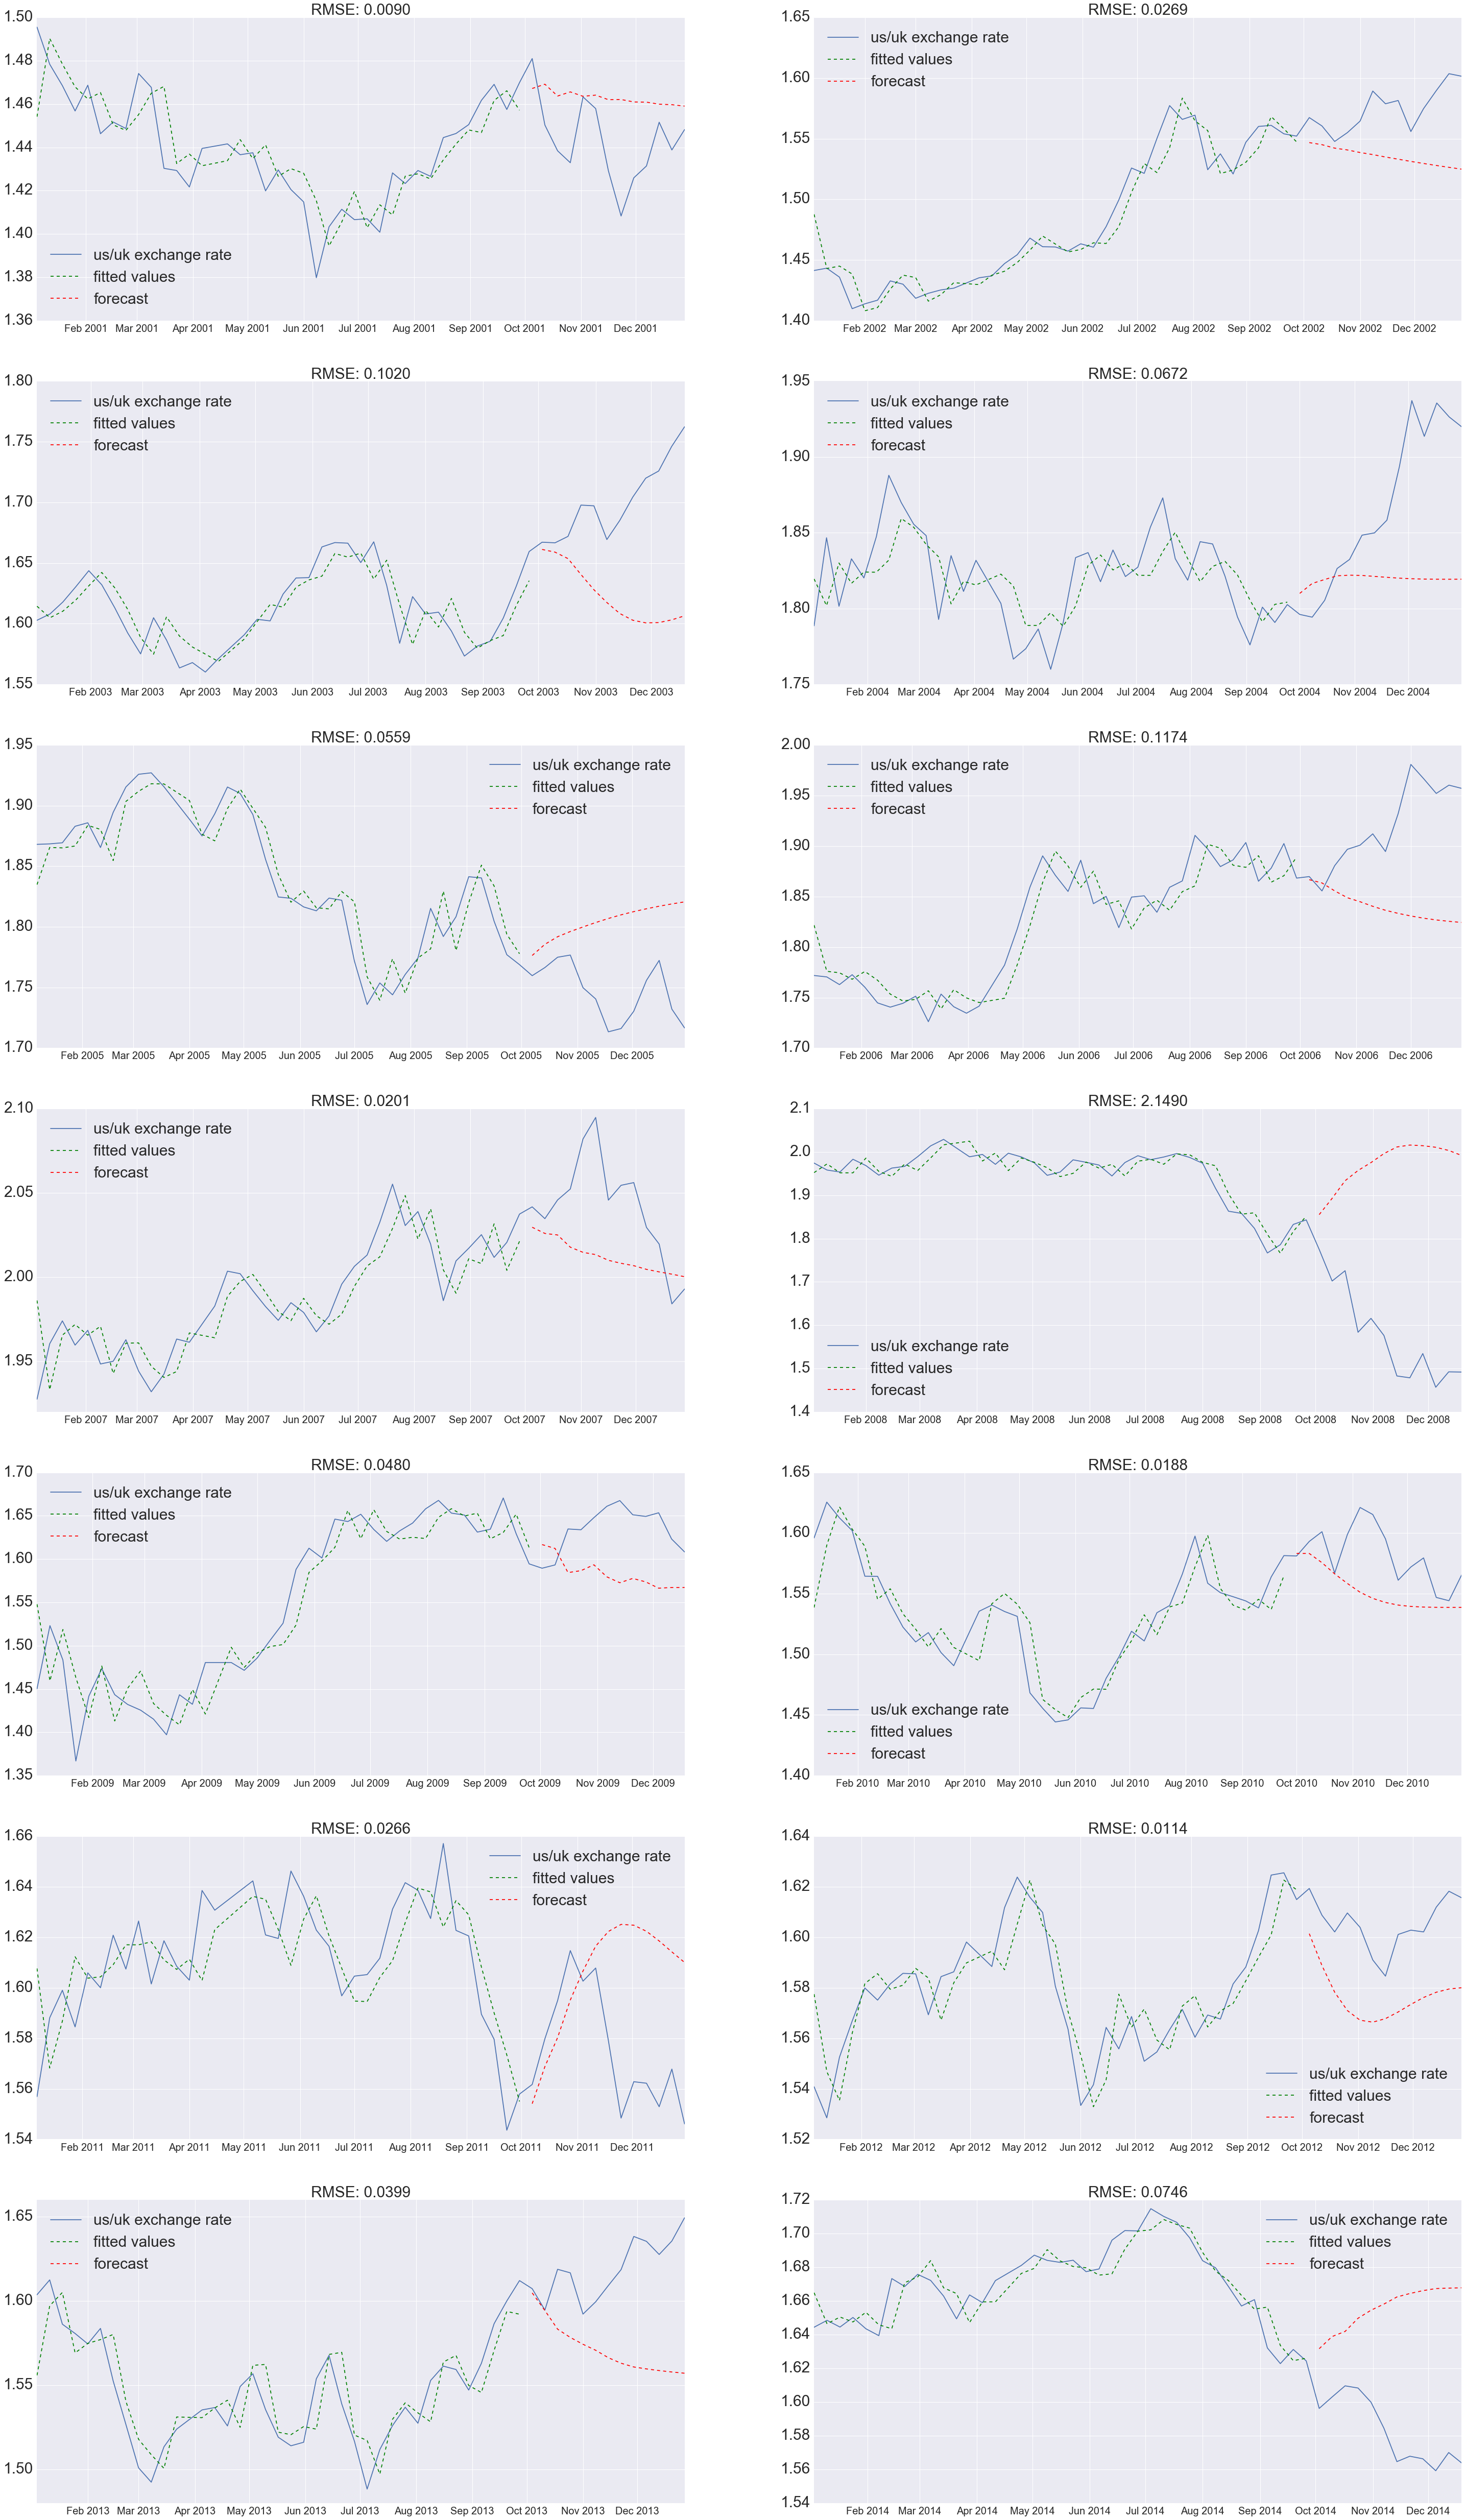

In [52]:
forecast_by_year(ts)

# Roll forward forecasting with variable horizons

- Forecast Prediction is done in the levels of the original endogenous variable (original variable no differencing)
- Model is fit for data 5 years prior to week t and prediction made for week t+1, t+2 etc depending on the horizon variable

Current model uses 3 lags, and first difference, with no moving average terms. 

In [28]:
def forecast_variable_horizon(ts, horizon, lags=3):
    # start predictions at 2006
    ts_2006 = ts['2006':]
    n_forecasts = len(ts_2006)
    actual_values = np.append(ts_2006.values, [0])
    
    # initialise empty array for forecast
    forecasts = np.zeros((n_forecasts+1, horizon+1))
    confidence_intervals = np.zeros((n_forecasts+1, 2, horizon+1))
    
    # choose a 5 year rolling window for predictions so current week - 5 years
    five_years = datetime.timedelta(weeks=260)
    
    # start at 2005
    for week_i, week in enumerate(ts_2006.index):
        
        # take the past 5 years as the training set
        ts_train = ts[week-five_years: week]
        
        model = ARIMA(ts_train, order=(lags, 1, 0))  
        results_ARIMA = model.fit(disp=-1)  
        
        forecast = results_ARIMA.forecast(horizon) # forecast for the horizon
        forecast_vals = forecast[0]
        forecast_conf_intervals = forecast[2]
        
        for f in range(1,horizon+1):
            if week_i <= n_forecasts - (f):
                forecasts[week_i+f, f] = forecast_vals[f-1]
                confidence_intervals[week_i+f, :, f] = forecast_conf_intervals[f-1,:]
                
                
                # start the prediction for the next week so the first prediction value will be zero as we
                # don't predict for the first week 
                
    newtime = np.datetime64(ts_2006.index[-1]+datetime.timedelta(weeks=horizon))
    new_time_index = pd.DatetimeIndex(np.append(ts_2006.index, newtime))
    
    forecast_df = pd.DataFrame({'actual': actual_values}, index=new_time_index)
    for col in range(horizon):
        forecast_df[col+1] = forecasts[:, col+1]
    return forecast_df, confidence_intervals                      

In [29]:
forecast_variable_horizon_df, confidence_intervals = forecast_variable_horizon(ts, 2)

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
forecast_variable_horizon_df.head()

actual         1         2
2006-01-06  1.7718  0.000000  0.000000
2006-01-13  1.7704  1.777330  0.000000
2006-01-20  1.7628  1.770988  1.777798
2006-01-27  1.7726  1.759897  1.767973
2006-02-03  1.7602  1.774432  1.761652

In [56]:
confidence_intervals_reindexed = confidence_intervals[1:]
confidence_intervals_reindexed[:,:,1]

array([[ 1.73830516,  1.81635405],
       [ 1.73198513,  1.80999168],
       [ 1.72091641,  1.79887661],
       ..., 
       [ 1.20619332,  1.27265623],
       [ 1.18705533,  1.25361449],
       [ 1.19257307,  1.25893003]])

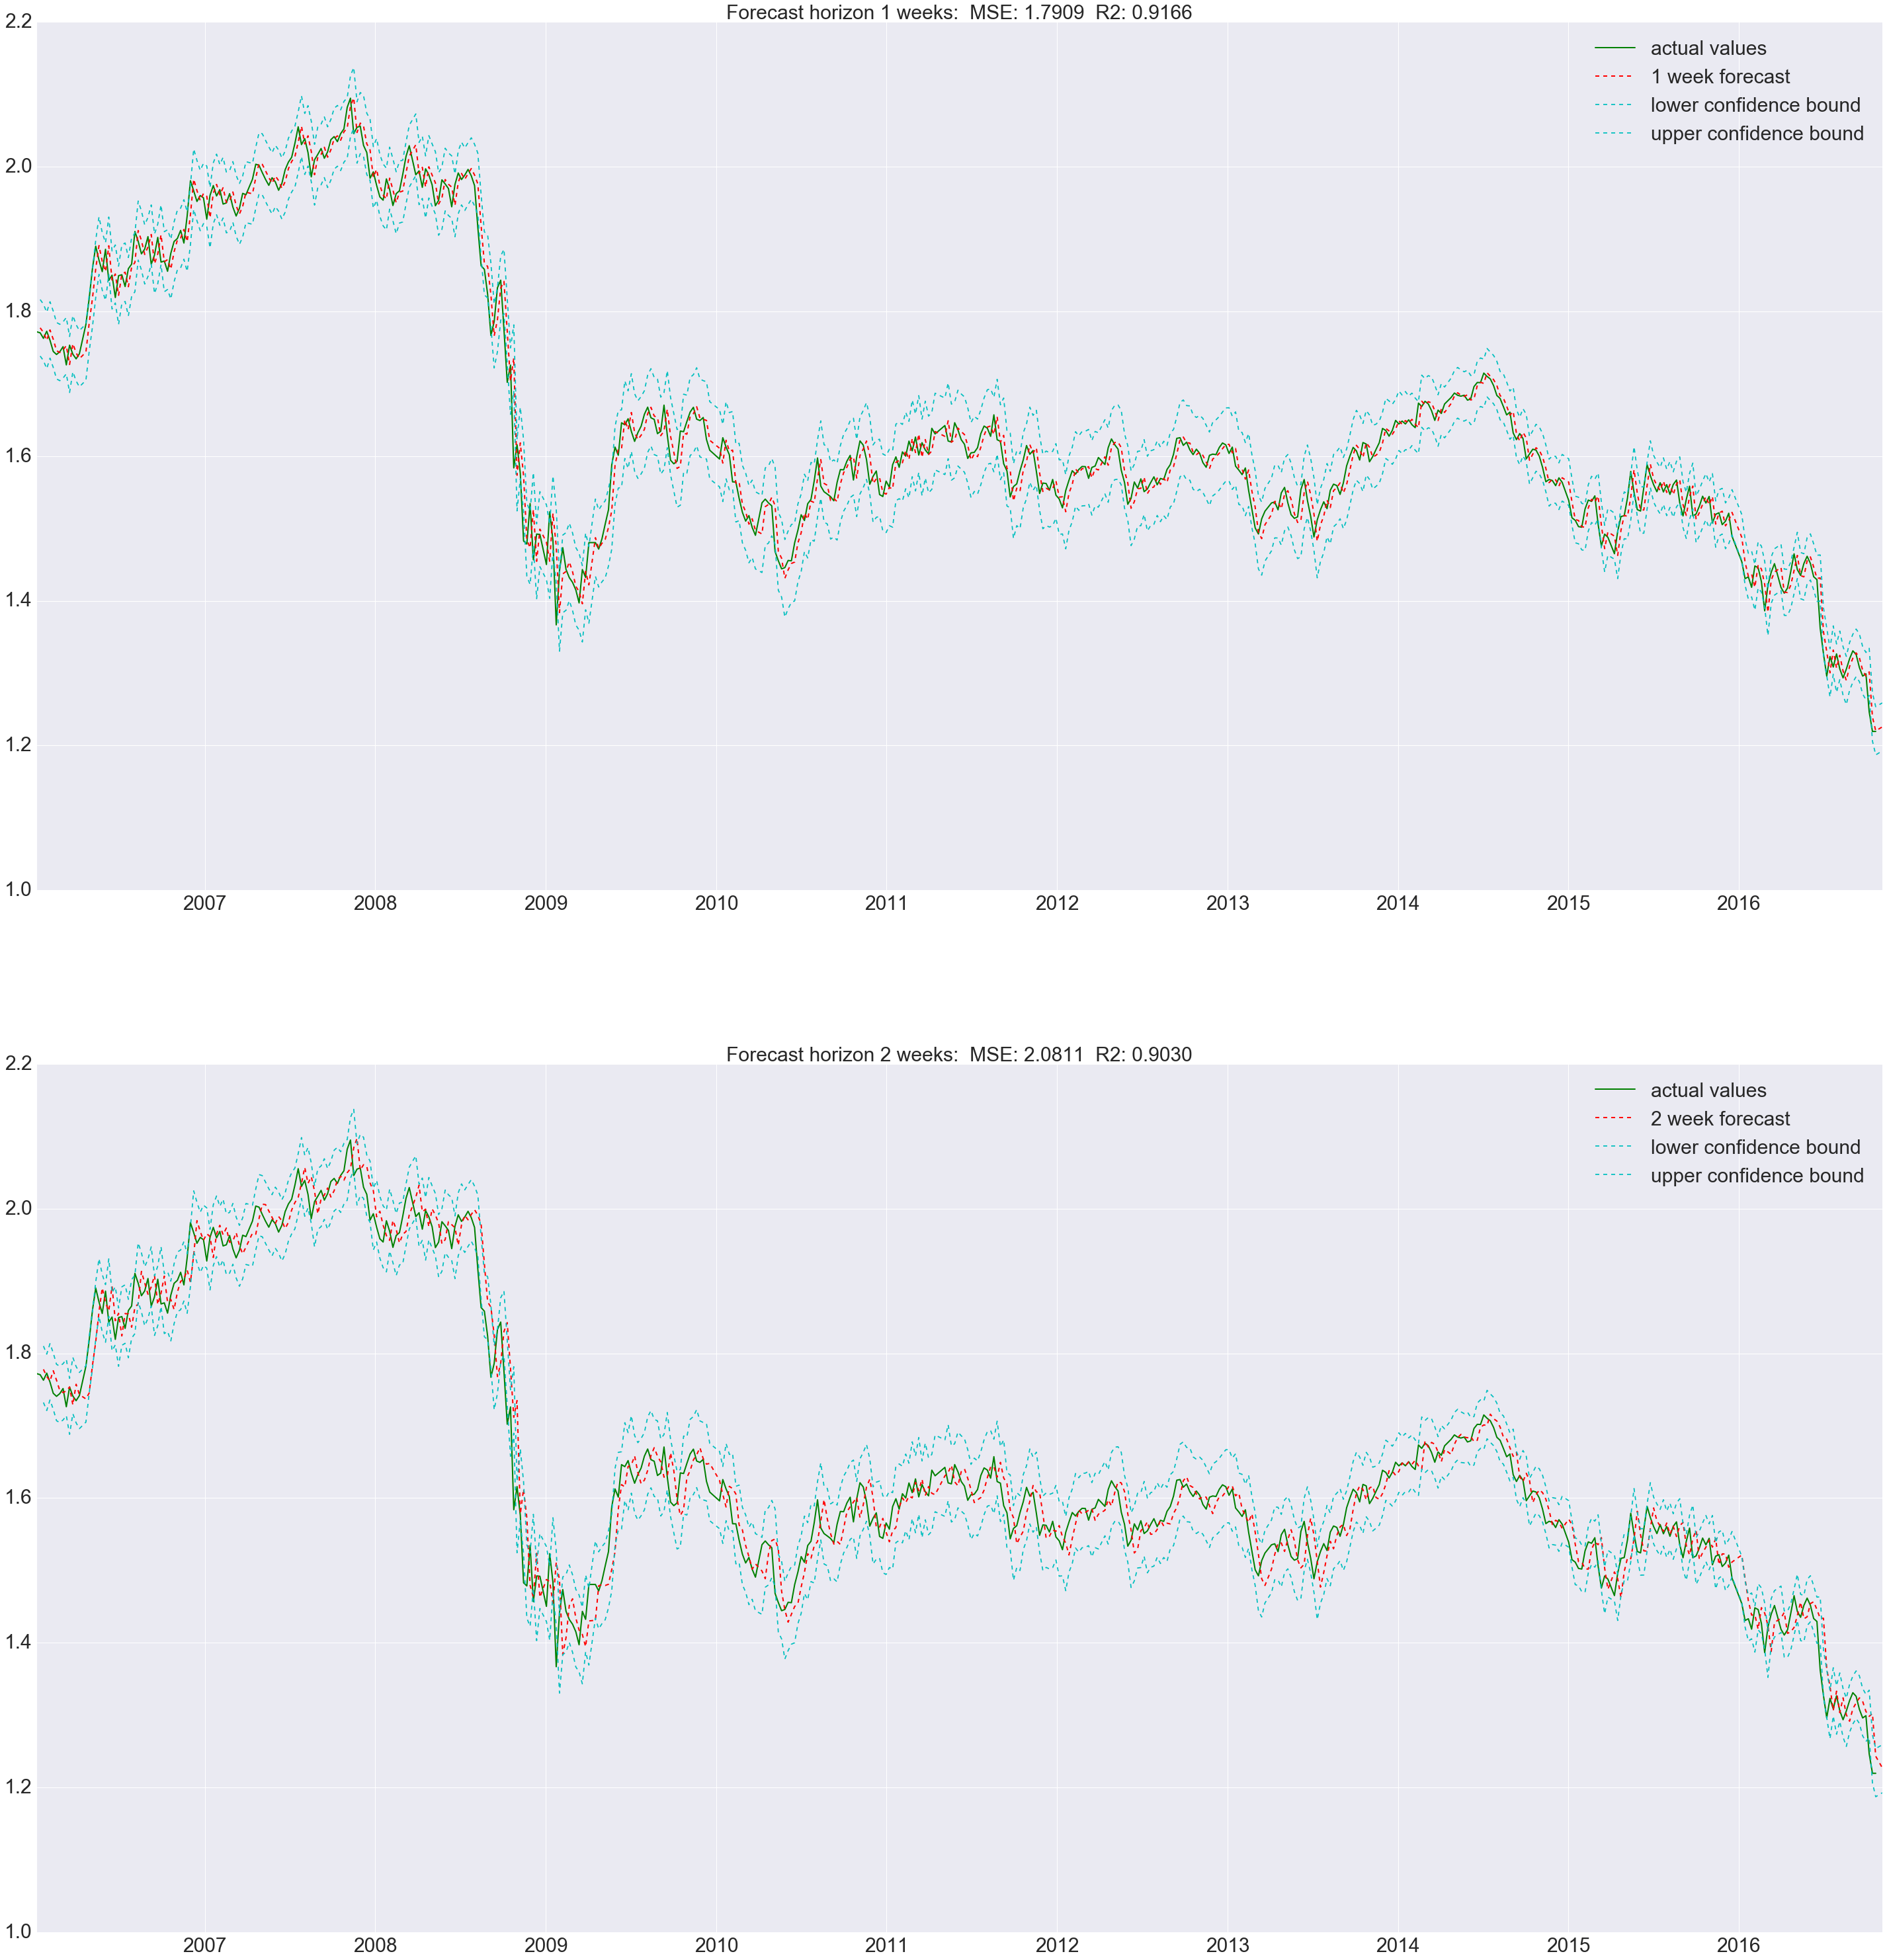

In [57]:
horizon = 2
plt.figure(figsize=(50,80))
j=0
for fc in range(1, horizon+1):
    j+=1
    plt.subplot(3, 1, j)
    plt.plot(forecast_variable_horizon_df['actual'][:-1], 'g', linewidth=2, label='actual values')
    plt.plot(forecast_variable_horizon_df.index[fc:], forecast_variable_horizon_df[fc][fc:], 'r--', linewidth=2, label=str(fc) +' week forecast')
    actual = forecast_variable_horizon_df['actual'][fc:]
    
    # confidence bounds:
    lower = confidence_intervals[:,:,1][fc:, 0]
    upper = confidence_intervals[:,:,1][fc:, 1]
    plt.plot(forecast_variable_horizon_df.index[fc:], lower, 'c--', label='lower confidence bound')
    plt.plot(forecast_variable_horizon_df.index[fc:], upper, 'c--', label='upper confidence bound')
    
    predicted = forecast_variable_horizon_df[fc][fc:]
    rmse = score(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    plt.title('Forecast horizon ' + str(fc) + ' weeks:  MSE: %.4f '% rmse + ' R2: %.4f' % r2, fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30, loc='best')

In [32]:
def forecast_variable_horizon_libor(ts, horizon, lags=3):
    # start predictions at 2006
    ts_2006 = ts['2006':]
    n_forecasts = len(ts_2006)
    actual_values = np.append(ts_2006.values, [0])
    
    # initialise empty array for forecast
    forecasts = np.zeros((n_forecasts+1, horizon+1))
    confidence_intervals = np.zeros((n_forecasts+1, 2, horizon+1))
    # choose a 5 year rolling window for predictions so current week - 5 years
    five_years = datetime.timedelta(weeks=30)
    
    # start at 2005
    for week_i, week in enumerate(ts_2006.index):
        
        # take the past 5 years as the training set
        ts_train = ts[week-five_years: week]
        model = ARIMA(ts_train, order=(lags, 1, 0), exog=libor)  
        results_ARIMA = model.fit(disp=-1)  
        forecast = results_ARIMA.forecast(horizon) # forecast for the horizon
        forecast_vals = forecast[0]
        forecast_conf_intervals = forecast[2]
        for f in range(1,horizon+1):
            if week_i <= n_forecasts - (f):
                forecasts[week_i+f, f] = forecast_vals[f-1]
                confidence_intervals[week_i+f, :, f] = forecast_conf_intervals[f-1,:]
                # start the prediction for the next week so the first prediction value will be zero as we
                # don't predict for the first week 
    newtime = np.datetime64(ts_2006.index[-1]+datetime.timedelta(weeks=horizon))
    new_time_index = pd.DatetimeIndex(np.append(ts_2006.index, newtime))
    forecast_df = pd.DataFrame({'actual': actual_values}, index=new_time_index)
    for col in range(horizon):
        forecast_df[col+1] = forecasts[:, col+1]
    return forecast_df, confidence_intervals                      

In [91]:
#??? INDICES NOT ALIGNED

# Zoom in on a time window

In [33]:
forecast_window = forecast_variable_horizon_df['2007':'2009']

In [34]:
forecast_window.head()

actual         1         2
2007-01-05  1.9275  1.959267  1.965302
2007-01-12  1.9604  1.929442  1.961308
2007-01-19  1.9740  1.963295  1.932456
2007-01-26  1.9596  1.975535  1.964923
2007-02-02  1.9684  1.961082  1.976874

In [35]:
def plot_prediction_window(forecast_variable_horizon_df, start_year, end_year):
    plt.figure(figsize=(20,10))
    start_index = len(forecast_variable_horizon_df['actual']) - len(forecast_variable_horizon_df['actual'][start_year:])
    end_index = start_index + len(forecast_variable_horizon_df['actual'][start_year:end_year])

    # slice the predictions dataframe:
    forecast_window = forecast_variable_horizon_df[start_year:end_year]

    # set forecast horizon
    fc = 2

    # plot the actual values and the forecast

    plt.plot(forecast_window['actual'][:-1], 'g', linewidth=2, label='actual values')
    plt.plot(forecast_window.index, forecast_window[fc], 'r--', linewidth=2, label=str(fc) +' week forecast')

    # plot the confidence bounds:
    lower = confidence_intervals[:,:,fc][start_index:end_index, 0]
    upper = confidence_intervals[:,:,fc][start_index:end_index, 1]

    plt.plot(forecast_window.index, lower, 'c--', label='lower confidence bound')
    plt.plot(forecast_window.index, upper, 'c--', label='upper confidence bound')

    predicted = forecast_window[fc]
    actual = forecast_window['actual']

    # score the predictions
    rmse = score(actual, predicted)
    r2 = r2_score(actual, predicted)

    # set plote legend
    plt.title('Forecast horizon ' + str(fc) + ' weeks:  MSE: %.4f '% rmse + ' R2: %.4f' % r2, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20, loc='best')

# Financial crisis

In [203]:
ts_train = ts['2002':'2007']
model = ARIMA(ts_train, order=(5, 1, 0))  
results_ARIMA = model.fit(disp=-1) 

In [205]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.UK_US   No. Observations:                  305
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 749.648
Method:                       css-mle   S.D. of innovations              0.021
Date:                Wed, 07 Dec 2016   AIC                          -1485.295
Time:                        17:04:07   BIC                          -1459.253
Sample:                    01-11-2002   HQIC                         -1474.879
                         - 12-28-2007                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0018      0.001      1.646      0.101        -0.000     0.004
ar.L1.D.UK_US    -0.0039      0.057     -0.068      0.946        -0.116     0.108
ar.L2.D.UK_US    -0.0483      0.057     -0.841      0.401        -0.161     0.064
ar.L3.D.UK_US     0.0020      0.058      0.035      0.972        -0.111     0.115
ar.L4.D.UK_US    -0.0281      0.058     -0.488      0.626        -0.141     0.085
ar.L5.D.UK_US     0.0053      0.058      0.093      0.926        -0.107     0.118
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5962           -1.6197j            2.2740           -0.3738
AR.2           -1.5962           +1.6197j            2.2740            0.3738
AR.3            1.3962           -2.1073j            2.5279           -0.1569
AR.4            1.3962           +2.1073j            2.5279            0.1569
AR.5            5.6673           -0.0000j            5.6673           -0.0000
-----------------------------------------------------------------------------
"""

(-0.2, 0.2)

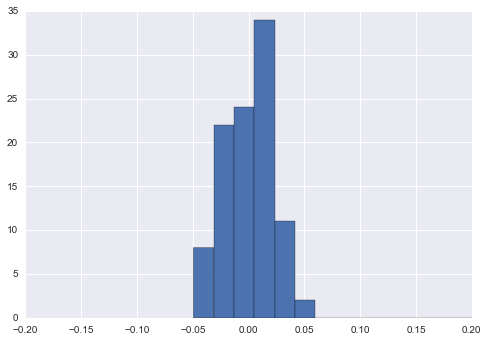

In [37]:
forecast_window = forecast_variable_horizon_df['2006': '2007']
plt.hist(((forecast_window['actual']-forecast_window[1])), bins=100)
plt.xlim([-0.2,0.2])

(-0.2, 0.2)

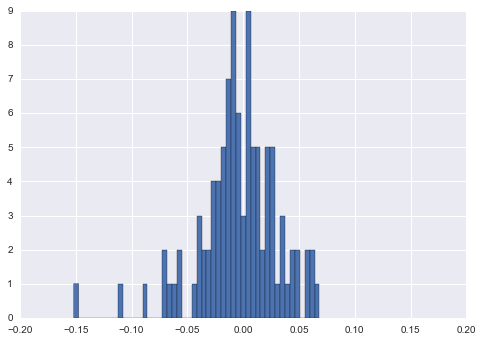

In [116]:
forecast_window = forecast_variable_horizon_df['2008': '2009']
plt.hist(((forecast_window['actual']-forecast_window[1])), bins=50)
plt.xlim([-0.2,0.2])

In [96]:
# results_ARIMA.summary()

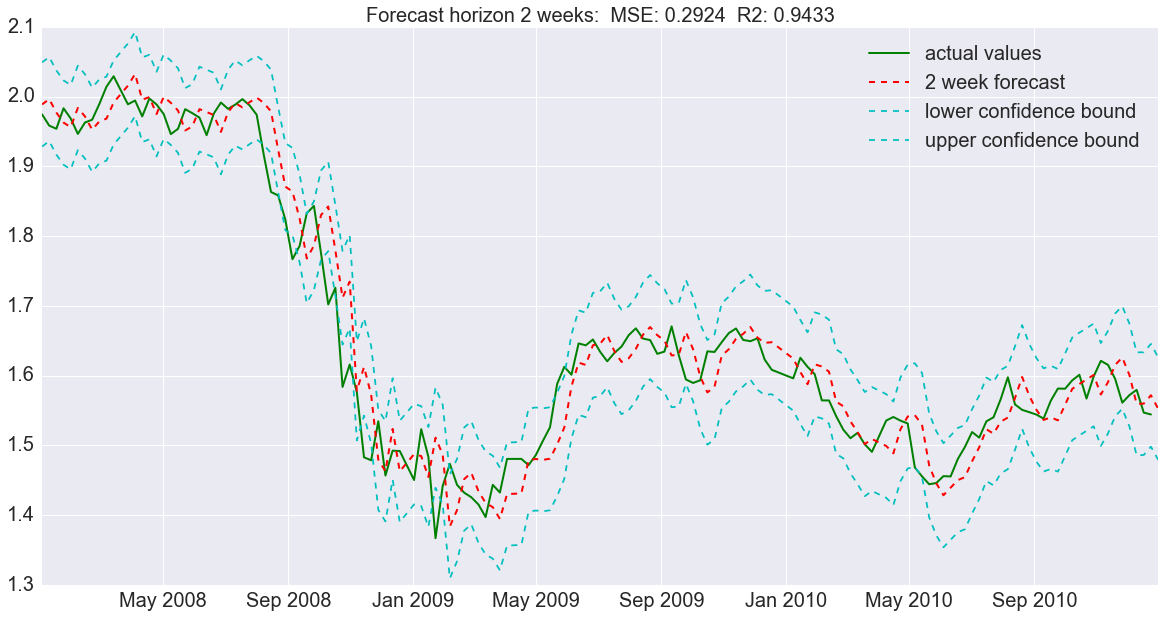

In [97]:
start_year = '2008'
end_year = '2010'
plot_prediction_window(forecast_variable_horizon_df, start_year, end_year)

# Brexit

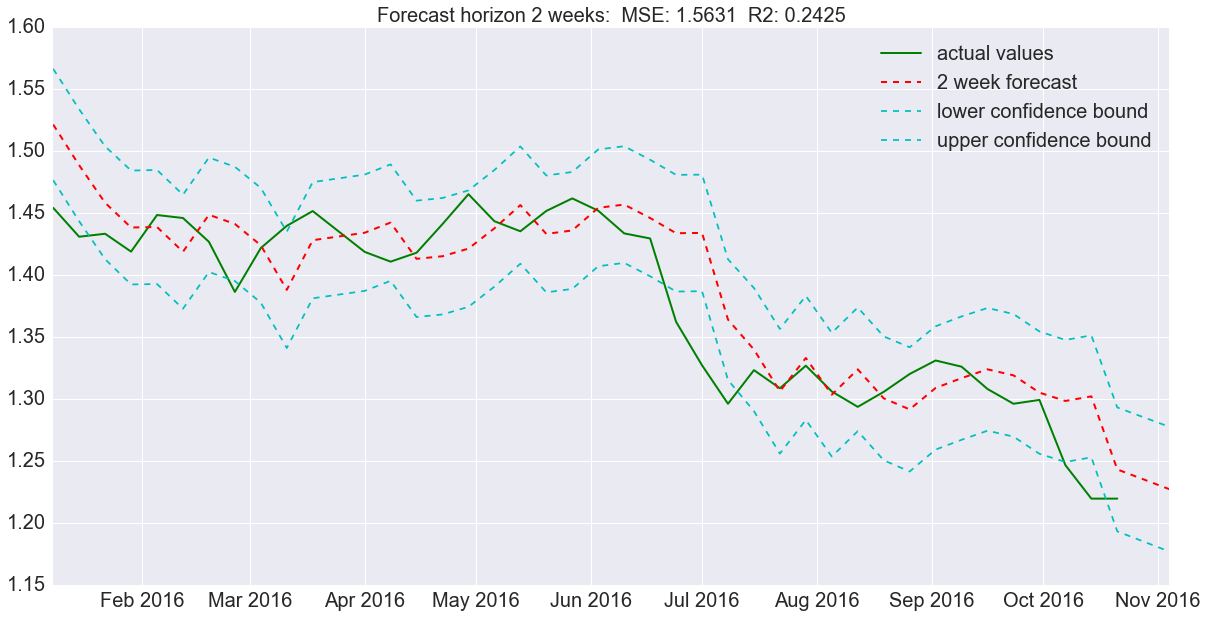

In [98]:
start_year = '2016'
end_year = '2016'
plot_prediction_window(forecast_variable_horizon_df, start_year, end_year)

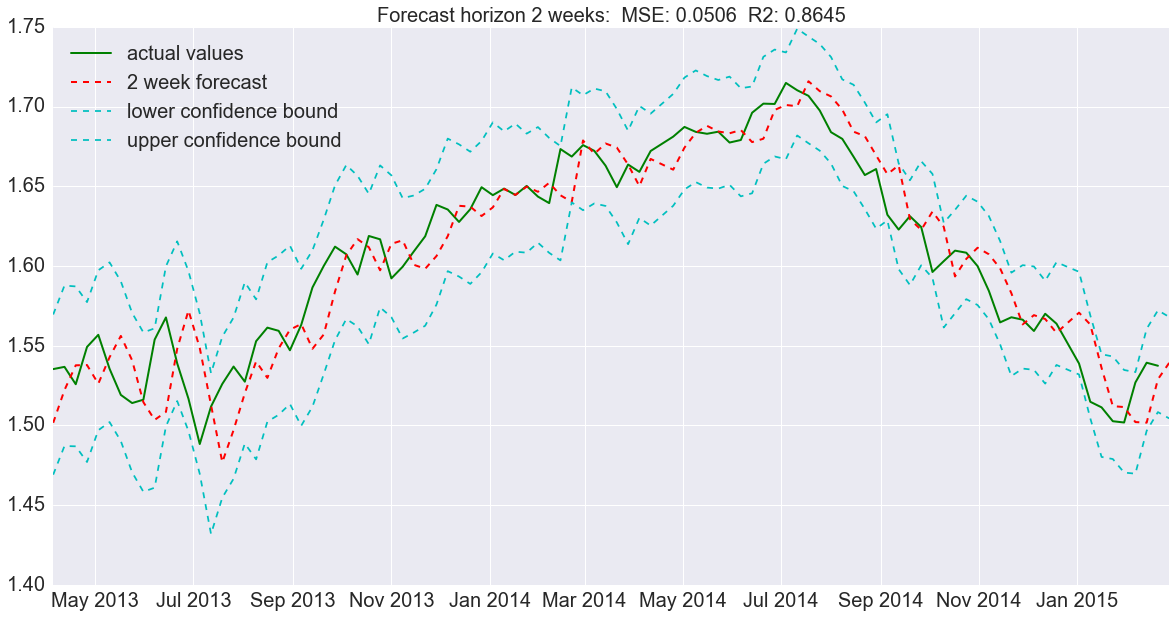

In [93]:
start_year = '2013-04'
end_year = '2015-02'
plot_prediction_window(forecast_variable_horizon_df, start_year, end_year)

# Roll Forward Cross Validation

Same concept as before, but the number of lags is varied - the average r2 is calculated after the model is fit to each subset and then averaged for each value of lag. The lag value at which the r2 is the lowest can then be selected. 

In [63]:
def roll_forward_cross_validate(ts, num_lags):
    scores = np.zeros((num_lags))
    for lag in range(1, num_lags+1):
        forecast_df, conf_int = forecast_variable_horizon(ts, 1, lag)
        scores[lag-1] = r2_score(forecast_df['actual'][1:], forecast_df[1][1:])
        print 'lag ', lag, 'score ', scores[lag-1]
    return scores
            

In [202]:
scores = roll_forward_cross_validate(ts, 5)

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


lag  1 score  0.91756959187


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


lag  2 score  0.917118893775


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


lag  3 score  0.916596332014
lag  4 score  0.916506172507


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


lag  5 score  0.916165311574


In [50]:
import math
def subset_ts(ts, n):
    length = len(ts.values)
    subset_length = math.floor((length/n))
    indices = ts.index.values
    subsets = []
    for i in range(n):
        start = subset_length*i
        end = subset_length*(i+1)
        subset_indices = indices[start:end]
        subset = ts[subset_indices]
        subsets.append(subset)
    return subsets

In [51]:
[ts_1, ts_2, ts_3, ts_5, ts_5] = subset_ts(ts, 5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


- Split time series into 5 sequential folds
- For each lag fit to one fold, predict on other 4
- Calculate r2
- Repeat for all lag values

In [60]:
def cross_validate_lags(lags, ts, k):
    subsets = subset_ts(ts, k)
    scores = np.zeros((len(lags), 1))
    for lag in lags:
        lag_r2 = []
        for i, subset in enumerate(subsets):
            model = ARIMA(subset, order=(lag, 1, 0))  
            results_ARIMA = model.fit(disp=-1)
            other_subsets_r2 = []
            for j, other_subset in enumerate(subsets):
                if i != j:
                    subset_indices = other_subset.index
                    predictions = results_ARIMA.predict(start=subset_indices[0], end=subset_indices[-1])
                    other_subsets_r2.append(r2_score(other_subset['actual'], predictions))
            lag_r2.append(np.mean(other_subset_r2))
            print 'lag ', lag, 'r2 ', np.mean(other_subset_r2)
        scores[i] = np.mean(lag_r2)
    return scores

In [62]:
# scores = cross_validate_lags([1,2,3,4,5], ts, 5)

# Generate Predictor matrix of lags for testing regression models

In [17]:
# start with an n x 20 matrix (i.e. for each time point, the columns are the lags at t=t-1, t=t-2 etc)
n_lags = 20
time_series_lags = np.zeros((len(ts), n_lags))

for n in range(1, n_lags+1):
    shifted = ts.shift(n)
    for index, val in enumerate(ts.values):
        if index > n_lags-1:
            time_series_lags[index, n-1] = shifted[index]

In [18]:
# start with an n x 20 matrix (i.e. for each time point, the columns are the lags at t=t-1, t=t-2 etc)
n_lags = 20
libor_series_lags = np.zeros((len(libor), n_lags))

for n in range(1, n_lags+1):
    shifted = libor.shift(n)
    for t, val in enumerate(libor.values):
        if t > n_lags-1:
            libor_series_lags[t, n-1] = shifted[t]

In [61]:
#np.savetxt("test.csv", time_series_lags, delimiter=",")

# Sentiment Analysis

In [103]:
sentiment_scores = pd.read_csv('../data_collection/scores_df.csv', delimiter=',')
sentiment_scores = sentiment_scores.set_index(pd.DatetimeIndex(sentiment_scores['weeks']))
sentiment_scores.drop('weeks', axis=1, inplace=True)

In [73]:
print sentiment_scores.index.unique()
print ts.index.unique()

DatetimeIndex(['2000-01-03', '2000-01-10', '2000-01-17', '2000-01-24',
               '2000-01-31', '2000-02-07', '2000-02-14', '2000-02-21',
               '2000-02-28', '2000-03-06',
               ...
               '2016-08-22', '2016-08-29', '2016-09-05', '2016-09-12',
               '2016-09-19', '2016-09-26', '2016-10-03', '2016-10-10',
               '2016-10-17', '2016-10-24'],
              dtype='datetime64[ns]', length=878, freq=None)
DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2016-08-19', '2016-08-26', '2016-09-02', '2016-09-09',
               '2016-09-16', '2016-09-23', '2016-09-30', '2016-10-07',
               '2016-10-14', '2016-10-21'],
              dtype='datetime64[ns]', length=852, freq=None)


In [82]:
new_index = sentiment_scores.apply(lambda row: row.index + datetime.timedelta(days=4))['avg_weekly_pos_score']

In [86]:
sentiment_scores = sentiment_scores.set_index(new_index)

## Filtering out weeks with no exchange rate data

The exchange rate data is extracted on a thursday and in some weeks if there was no trading on a thursday then the exchange rate data is not present for that week in our extracted time series so there are  fewer weeks in the exchange rate data than for articles. Need to make sure the weeks match in both sentiment scores and exchange rate time series. 

In [99]:
print sentiment_scores.index.unique()
print ts.index.unique()

DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2016-08-26', '2016-09-02', '2016-09-09', '2016-09-16',
               '2016-09-23', '2016-09-30', '2016-10-07', '2016-10-14',
               '2016-10-21', '2016-10-28'],
              dtype='datetime64[ns]', name=u'avg_weekly_pos_score', length=878, freq=None)
DatetimeIndex(['2000-01-07', '2000-01-14', '2000-01-21', '2000-01-28',
               '2000-02-04', '2000-02-11', '2000-02-18', '2000-02-25',
               '2000-03-03', '2000-03-10',
               ...
               '2016-08-19', '2016-08-26', '2016-09-02', '2016-09-09',
               '2016-09-16', '2016-09-23', '2016-09-30', '2016-10-07',
               '2016-10-14', '2016-10-21'],
              dtype='datetime64[ns]', length=852, freq=None)


In [100]:
ts_df = pd.DataFrame(data=ts)

In [101]:
ts_df.head()

UK_US
2000-01-07  1.6372
2000-01-14  1.6349
2000-01-21  1.6506
2000-01-28  1.6198
2000-02-04  1.5886

In [102]:
time_series_filtered = ts_df.merge(sentiment_scores, right_index=True, left_index=True)

In [104]:
pos = time_series_filtered['avg_weekly_pos_score']
neg = time_series_filtered['avg_weekly_neg_score']
ts_filtered = time_series_filtered['UK_US']

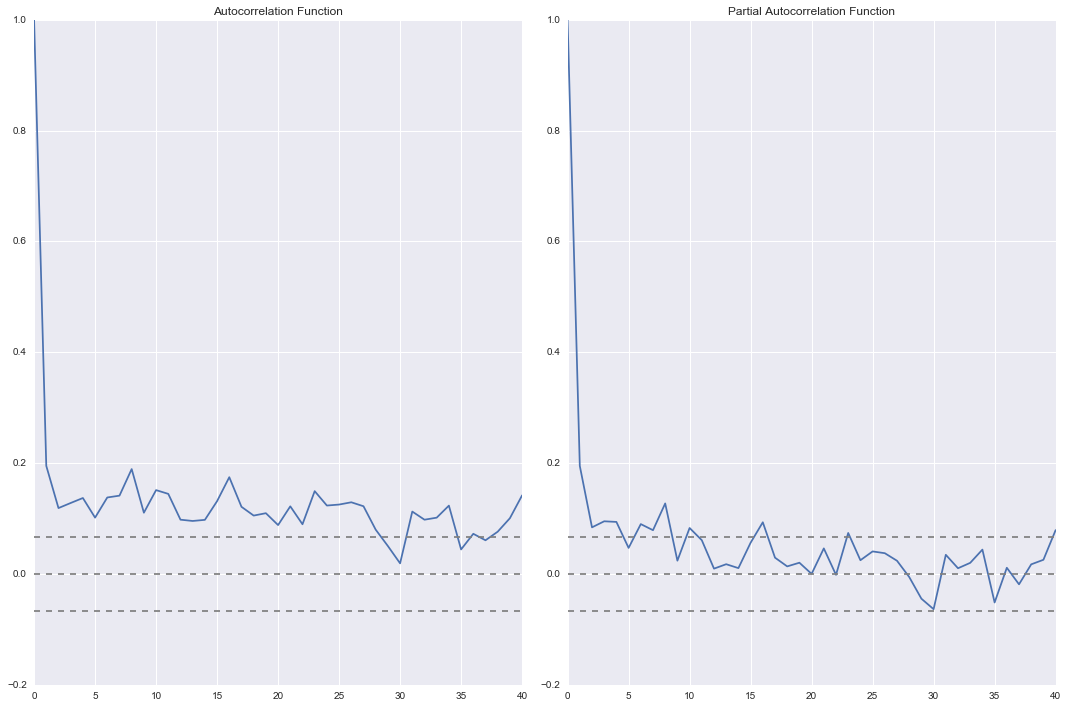

In [40]:
lag_acf = acf(pos, nlags=40)
lag_pacf = pacf(pos, nlags=40, method='ols')

#Plot ACF: 
plt.figure(figsize=(15,10))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pos)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [148]:
n_lags = 20
pos_sentiment_lags = np.zeros((len(pos.values), n_lags))

for n in range(1, n_lags+1):
    shifted = pos.shift(n)
    for t, val in enumerate(pos.values):
        if t > n_lags-1:
            pos_sentiment_lags[t, n-1] = shifted[t]
            
n_lags = 20
neg_sentiment_lags = np.zeros((len(neg.values), n_lags))

for n in range(1, n_lags+1):
    shifted = neg.shift(n)
    for t, val in enumerate(neg.values):
        if t > n_lags-1:
            neg_sentiment_lags[t, n-1] = shifted[t]
            
n_lags = 20
time_series_filtered_lags = np.zeros((len(ts_filtered.values), n_lags))

for n in range(1, n_lags+1):
    shifted = ts_filtered.shift(n)
    for index, val in enumerate(ts_filtered.values):
        if index > n_lags-1:
            time_series_filtered_lags[index, n-1] = shifted[index]

# Multivariate Arima model with sentiment scores

In [142]:
def forecast_variable_horizon_exog(ts, horizon, sentiments, lags=3):
    # start predictions at 2006
    ts_2006 = ts['2006':]
    n_forecasts = len(ts_2006)
    actual_values = np.append(ts_2006.values, [0])
    
    # initialise empty array for forecast
    forecasts = np.zeros((n_forecasts+1, horizon+1))
    confidence_intervals = np.zeros((n_forecasts+1, 2, horizon+1))
    # choose a 5 year rolling window for predictions so current week - 5 years
    five_years = datetime.timedelta(weeks=30)
    
    # start at 2005
    for week_i, week in enumerate(ts_2006.index):
        
        # take the past 5 years as the training set
        ts_train = ts[week-five_years: week]
        
        # subset the sentiment scores as well
        sentiment_train = []
        for sentiment in sentiments:
            sentiment_train.append(sentiment[week-five_years: week])
        sentiment_train = np.array(sentiment_train).reshape((len(ts_train), len(sentiments)))
        
        # train the model 
        model = ARIMA(ts_train, order=(lags, 1, 0), exog=sentiment_train)  
        results_ARIMA = model.fit(disp=-1)  
        
        # forecast 
        forecast = results_ARIMA.forecast(horizon) # forecast for the horizon
        forecast_vals = forecast[0]
        forecast_conf_intervals = forecast[2]
        for f in range(1,horizon+1):
            if week_i <= n_forecasts - (f):
                forecasts[week_i+f, f] = forecast_vals[f-1]
                confidence_intervals[week_i+f, :, f] = forecast_conf_intervals[f-1,:]
                # start the prediction for the next week so the first prediction value will be zero as we
                # don't predict for the first week 
    newtime = np.datetime64(ts_2006.index[-1]+datetime.timedelta(weeks=horizon))
    new_time_index = pd.DatetimeIndex(np.append(ts_2006.index, newtime))
    forecast_df = pd.DataFrame({'actual': actual_values}, index=new_time_index)
    for col in range(horizon):
        forecast_df[col+1] = forecasts[:, col+1]
    return forecast_df, confidence_intervals 

In [143]:
forecast_variable_horizon_df, confidence_intervals = forecast_variable_horizon_exog(ts, 1, [pos, neg], lags=4)

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

# Ridge regularisation

In [699]:
def ridge_predict(predictor_arrays):
    predictors = np.concatenate(predictor_arrays, axis=1)
    predictor_matrix_df = pd.DataFrame(data=predictors, index=ts.index.values)
    predictor_matrix_df_trimmed = predictor_matrix_df[20:-20]
    predictor_matrix_df_subset_1 = predictor_matrix_df_trimmed['2000':'2016']
#     predictor_matrix_df_subset_2 = predictor_matrix_df_trimmed['2006':'2016']
    
    # split into train and test sets 
    test_indices = predictor_matrix_df_subset_1.sample(frac=0.4).index
    train_indices = predictor_matrix_df_subset_1.drop(test_indices).index
    
    print 'Xtrain shape ', train_indices.shape
    print 'Xtest shape ', test_indices.shape
    
    # sort test index values to help with plotting 
    sorted_test_indices = test_indices.order()
    
    X_train = predictor_matrix_df_trimmed.ix[train_indices]
    X_test = predictor_matrix_df_trimmed.ix[sorted_test_indices]
    y_train = ts[train_indices].values
    y_test = ts[sorted_test_indices].values
    
    # fit ridge regression model
    ridge_cv = linear_model.LassoCV(normalize=True, cv=30, fit_intercept=True)
    ridge_cv.fit(X_train, y_train)
    
    # plot coefficients
    plt.figure(figsize=(15,10))
    plt.plot(ridge_cv.coef_)
#     plt.title('Lasso regression coefficients')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lags', fontsize=20)
    plt.ylabel('Coefficient', fontsize=20)
    
    # validation set predictions
    test_predictions = ridge_cv.predict(X_test)
    
    # plot predictions
    
    plt.figure(figsize=(15,10))
    plt.scatter(sorted_test_indices, test_predictions, color='red', label='predictions')
    plt.scatter(sorted_test_indices, y_test, label='actual')
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Time (weeks)', fontsize=20)
    plt.ylabel('Exchange rate', fontsize=20)
    print 'score ', str(r2_score(y_test, test_predictions))
#     plt.title('Test predictions,  $R^2$ = ' + str(r2_score(y_test, test_predictions)))
    
    
    ## residual histogram
    plt.figure(figsize=(15,10))
    plt.hist((test_predictions-y_test), bins=100)
#     plt.title('Residuals')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Residual Error', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    
    return ridge_cv

Xtrain shape  (487,)
Xtest shape  (325,)
score  0.984607854568


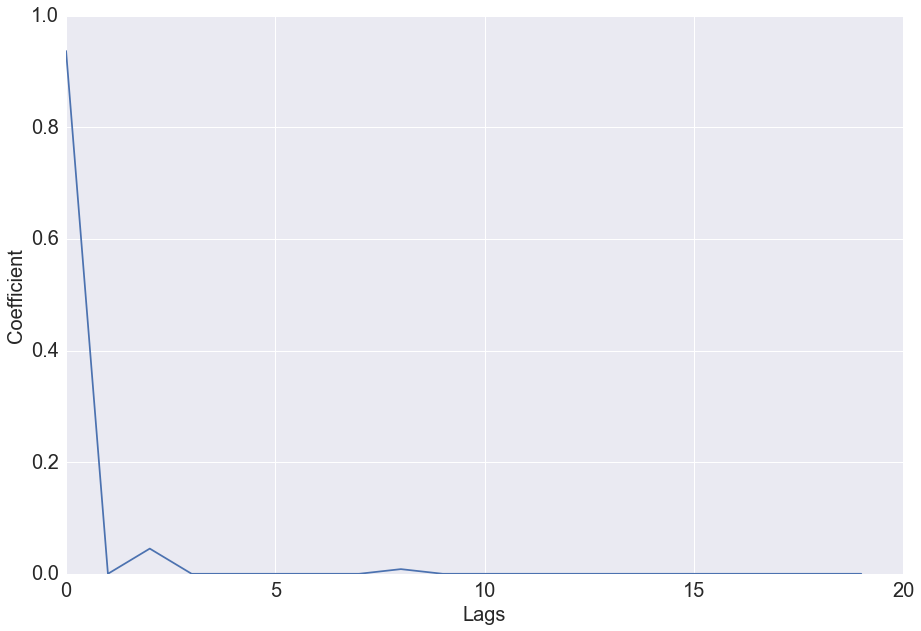

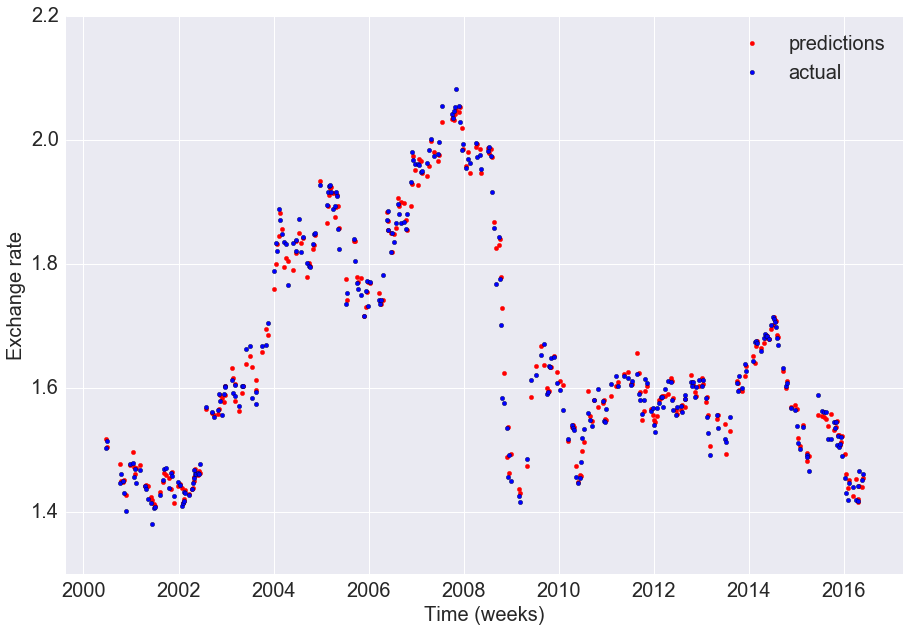

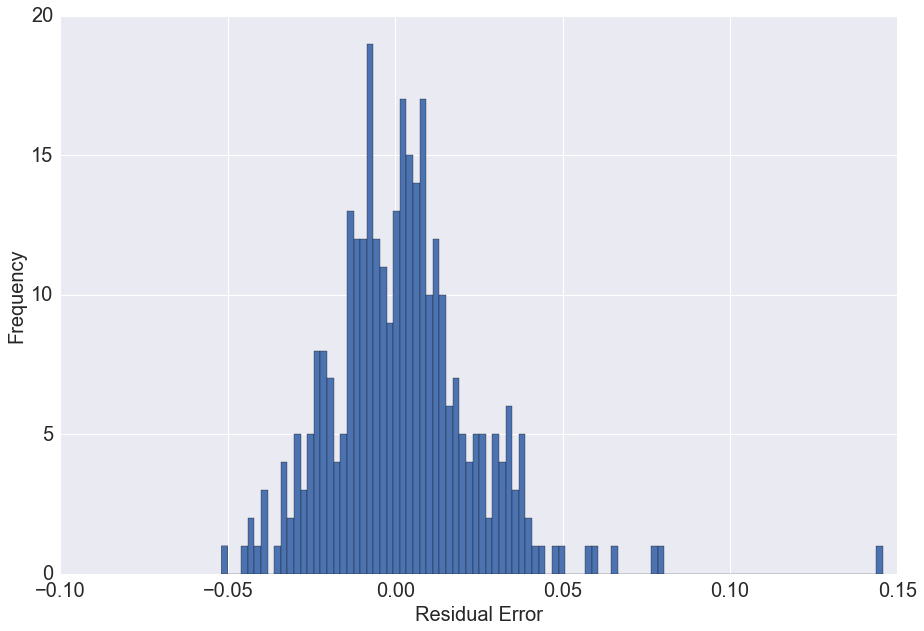

In [700]:
ridge_model = ridge_predict([time_series_filtered_lags])

## Multivariate regression

Xtrain shape  (487,)
Xtest shape  (325,)
score  0.979535754103


LassoCV(alphas=None, copy_X=True, cv=30, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

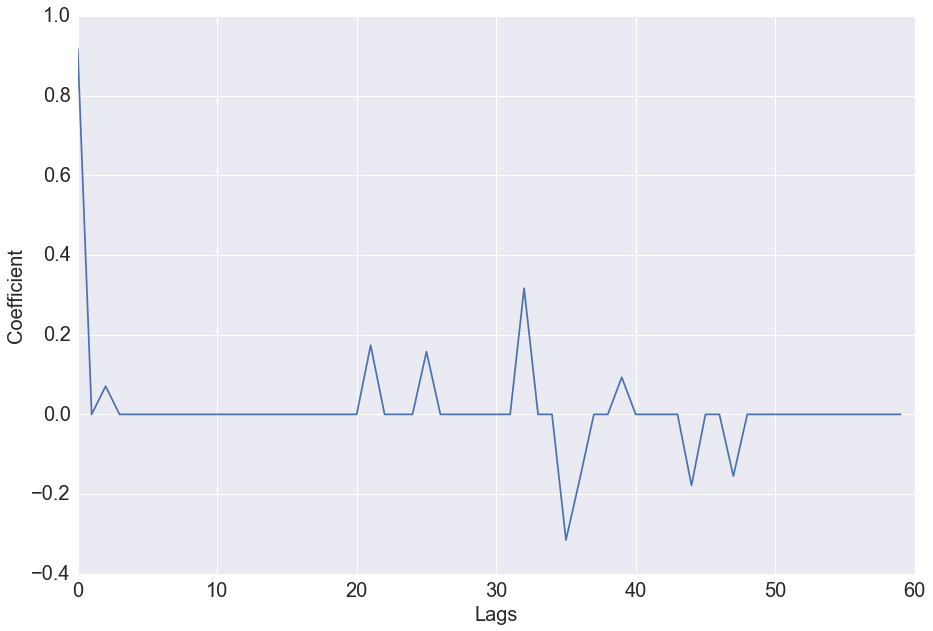

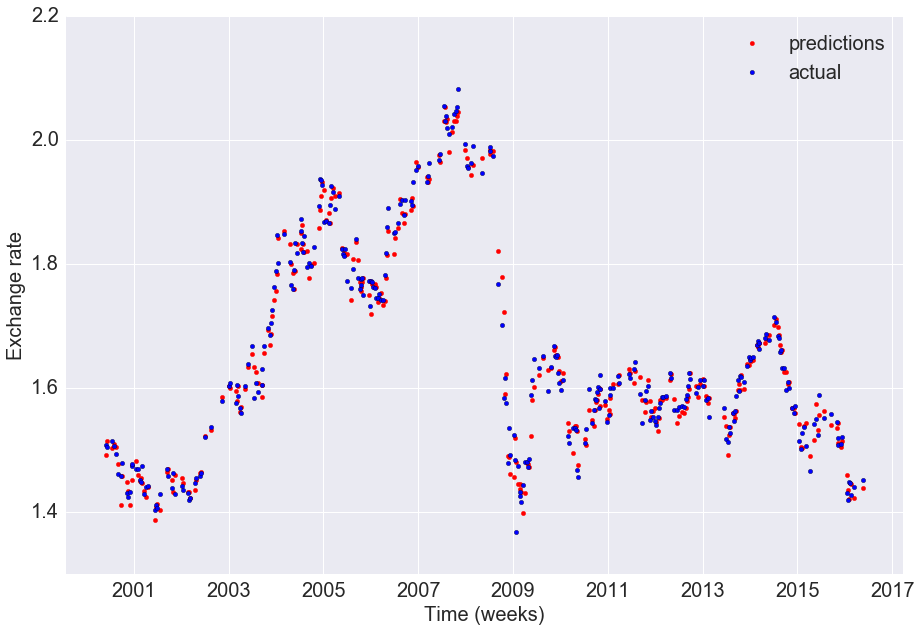

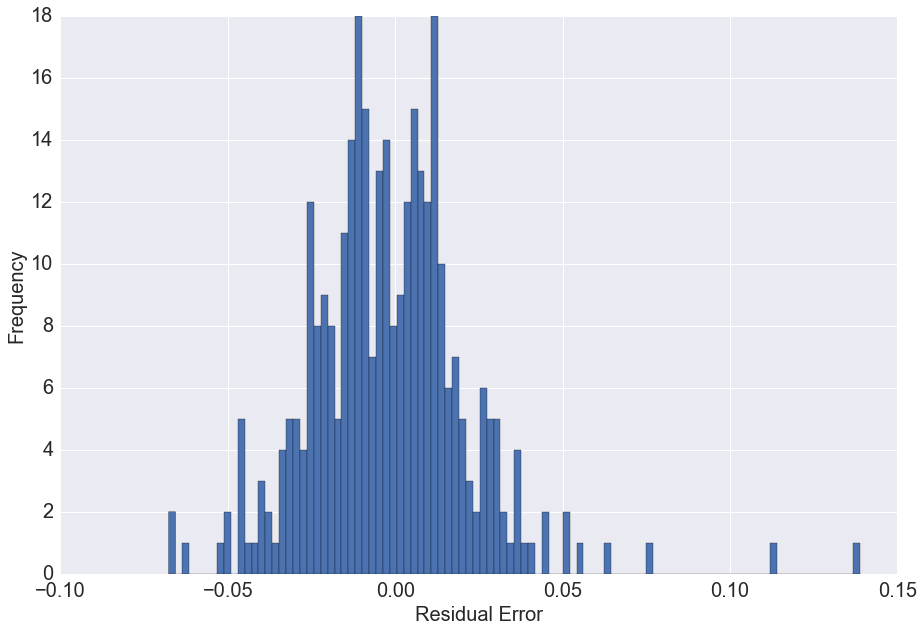

In [703]:
ridge_predict([time_series_filtered_lags, pos_sentiment_lags, neg_sentiment_lags])

## Forecasting based on regression model

In [685]:
def forecast(model, n, x_test, last_date):
    predictions = []
    # create future dates
    week = datetime.timedelta(days=7)
    dates = np.array([(last_date + n*week) for n in range(1, n+1)])
    
    # set the x_test value
    x_s = x_test
    
    # for each forecast timestep
    for t in range(0, n):
        if t > 0:
            # concatenate the prediction from the previous timestep to the current predictor set to get the lag values 
            # for the next timestep
            x_s = np.concatenate((predictions, x_test), axis=0)
            
        # take the first 20 values to predict the next timestep
        x_s = x_s[0:20]
        
        #predict based on the lags
        p = np.array(model.predict(x_s))
        
        # prepend to the forecasts array so the prediction will be in the correct order for the next prediction
        if t > 0:
            predictions = np.concatenate((p, predictions), axis=0)
        else:
            predictions = p 
        # reverse the predictions so they are in the correct order 
    return predictions[::-1], dates

In [686]:
def predict_n_weeks(n, ts_filtered):
    #model is traned with 20 lags
    num_lags = 20
    
    colors = ['red', 'green', 'yellow', 'orange', 'magenta', 'blue']    

    # initialise
    plt.figure(figsize=(15,15))
    prediction_n_week = np.zeros((len(ts_filtered)-num_lags))
    prediction_dates = []
    
    # for each time step, predict n weeks ahead:
    for i in range(num_lags, len(ts_filtered)):
        last_date = ts_filtered.index[i]
        
        # take last 20 values of df to generate forecasts for time i+1, i+2, i+3 etc 
        # (and reverse so it is in the order [t-1, t-2, t-3....]
        x_test = ts_filtered.iloc[i-num_lags:i+1].values[::-1]  
        # array index from i-20:i+1 as otherwise value for time i is not inclusive
        
        # forecast
        predictions_t, dates_t = forecast(ridge_model, n, x_test, last_date)
        
        plt.plot(dates_t, predictions_t, color=np.random.choice(colors))
        plt.plot()
        
        # save last value
        prediction_n_week[i-num_lags] = predictions_t[-1]
        date = dates_t[-1]
        
#         print 'last_date', last_date, 'prev_value',x_test[0],  'next_date', date, 'prediction', predictions_t[-1]
        prediction_dates.append(date)
        
    plt.plot(ts_filtered.index, ts_filtered.values, linestyle='dashed')
    plt.xlabel('Time (weeks)', fontsize=20)
    plt.ylabel('Exchange Rate', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    return prediction_n_week, prediction_dates

R2 1 week:  0.980185881408
R2 20 week:  0.945723889952


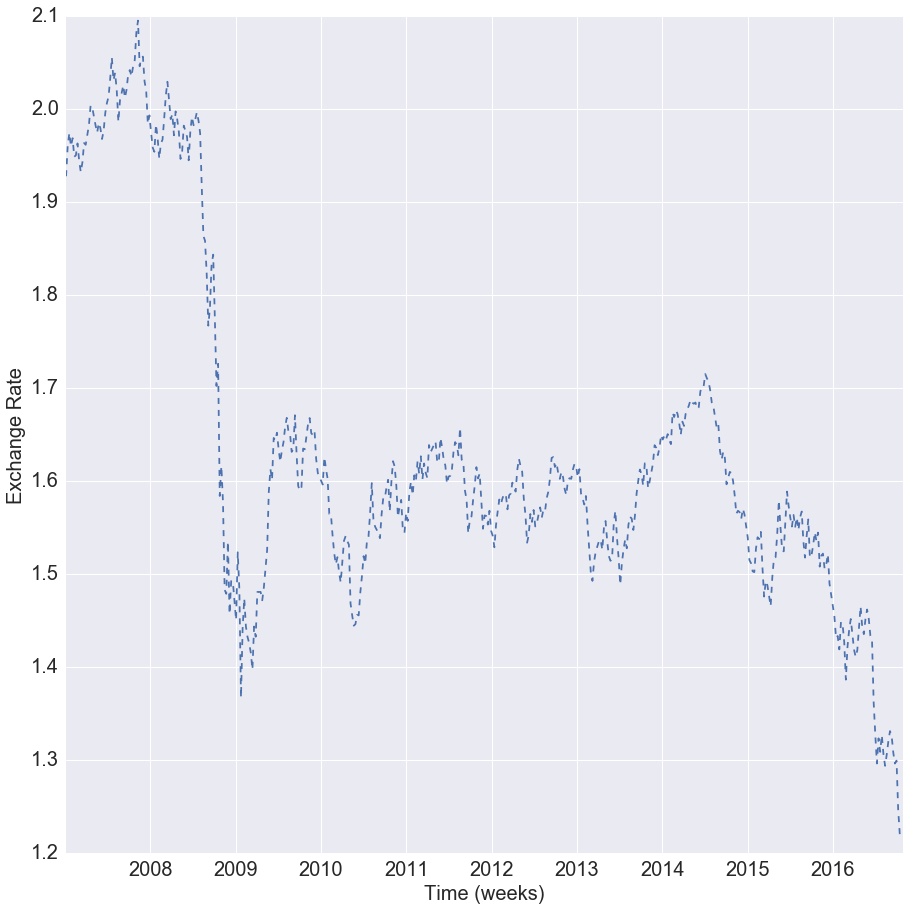

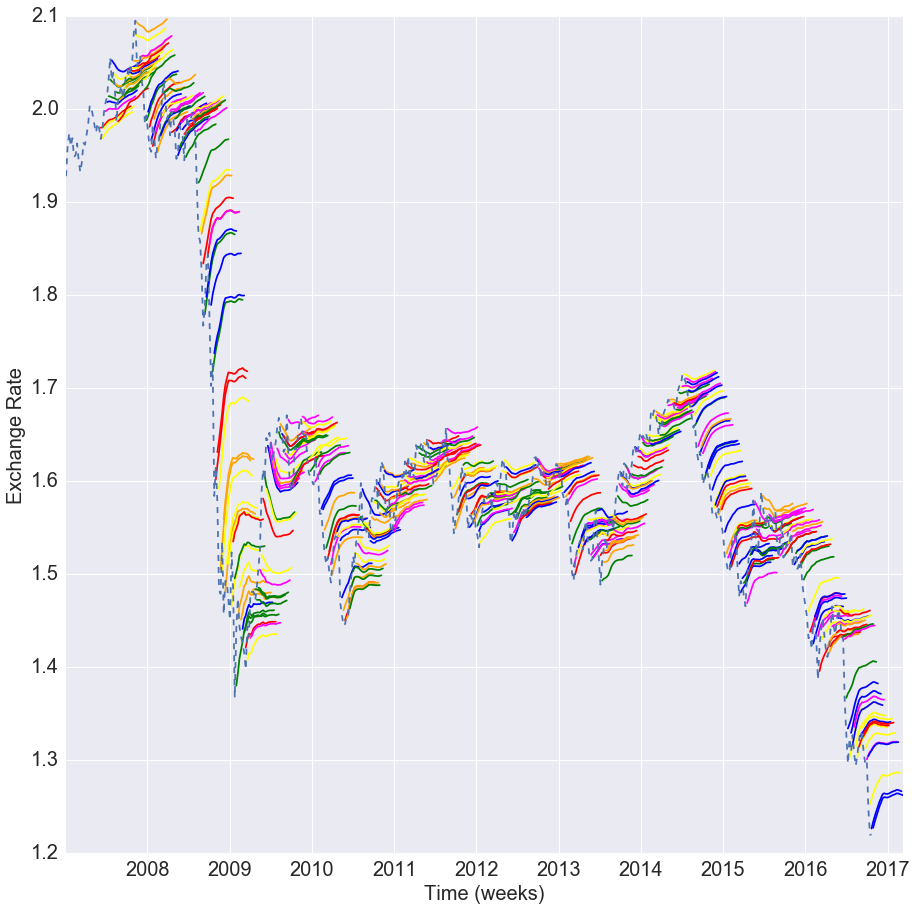

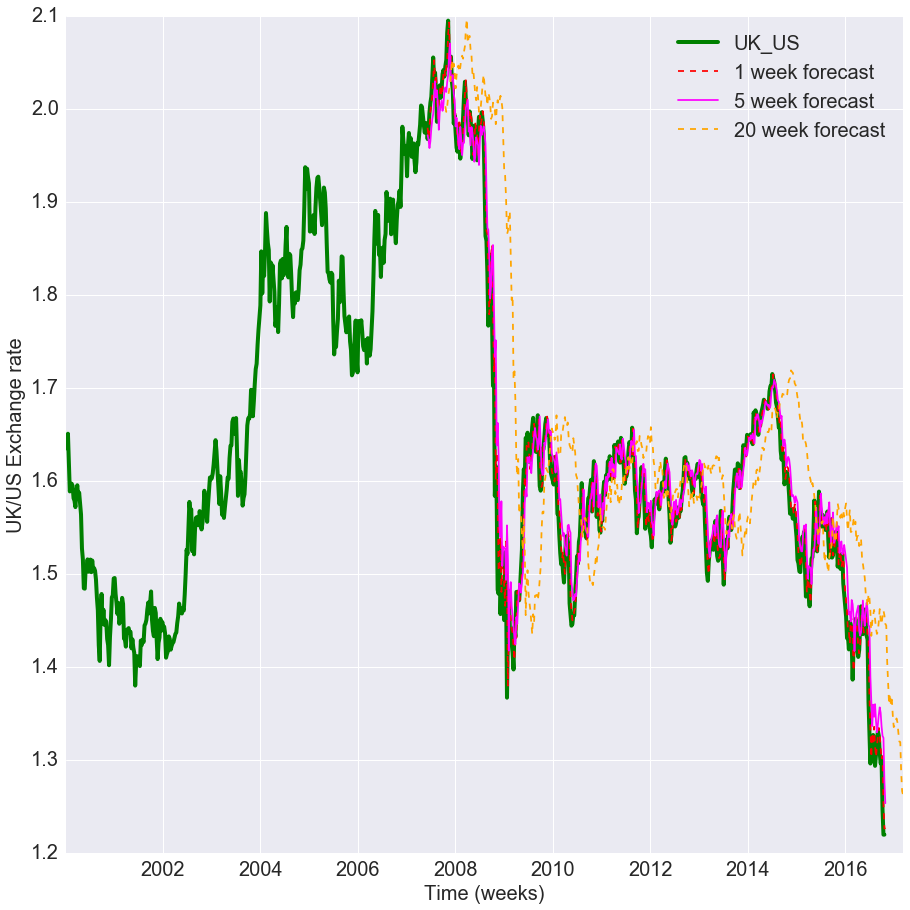

In [689]:
ts_train = ts_filtered['2007':'2016']
ts_predict = ts_filtered['2007':'2016'].values[21:]

# 1 week look ahead forecast
prediction_1_week, prediction_dates_1 = predict_n_weeks(1, ts_train)
r2_1_week = r2_score(ts_predict, prediction_1_week[:-1])
print 'R2 1 week: ', r2_1_week

# # 5 week look ahead forecast
# prediction_5_week, prediction_dates_2 = predict_n_weeks(5, ts_train)

# # 10 week look ahead forecast
# prediction_10_week, prediction_dates_3 = predict_n_weeks(10, ts_train)

# 20 week look ahead forecast
prediction_20_week, prediction_dates_4 = predict_n_weeks(20, ts_train)
r2_20_week = r2_score(ts_predict, prediction_20_week[:-1])
print 'R2 20 week: ', r2_20_week

plt.figure(figsize=(15,15))

# actual values
plt.plot(ts_filtered.index, ts_filtered, linewidth=4, color='green')

# 1 week forecast
plt.plot(prediction_dates_1, prediction_1_week, color='red', linestyle='dashed', label='1 week forecast')
plt.plot(prediction_dates_2, prediction_5_week, color='magenta', label='5 week forecast')
# plt.plot(prediction_dates_3, prediction_10_week, color='magenta', label='10 week forecast')
plt.plot(prediction_dates_4, prediction_20_week, color='orange', linestyle='dashed',label='20 week forecast')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('UK/US Exchange rate', fontsize=20)
plt.xlabel('Time (weeks)', fontsize=20)
plt.legend(fontsize=20)


In [ ]:
x_train = ts_filtered
x_test = x_train.iloc[-20:].values[::-1]
last_date = x_train.index[-1]
predictions, dates = forecast(ridge_model, 40, x_test, last_date)

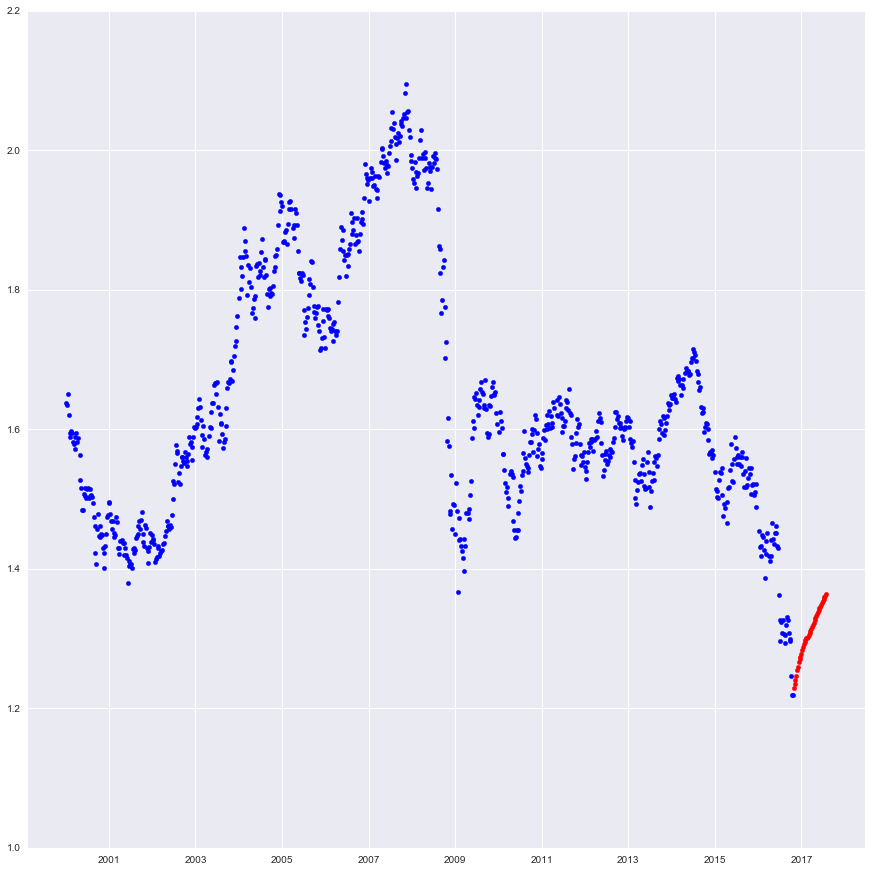

In [578]:
plt.figure(figsize=(15,15))
plt.scatter(dates, predictions, color='red')
plt.scatter(ts_filtered.index, ts_filtered.values, color='blue')

## Trying different Sentiment Scores 